In [71]:
import os
if os.getcwd().replace("\\", "/").split("/")[-1] in ["notebooks", "scripts"]:
    os.chdir("..")


# the model

In [72]:
import duckdb
import pandas as pd
import numpy as np
from time import time
import matplotlib.pyplot as plt

## get the data & encode

In [73]:
table = "sandbox_T_apartment_S_ca_preprocessed"

In [74]:
con = duckdb.connect('data/exploitation.db', read_only=True)
df = con.execute(f"select * from {table}").df()
df.head()

,region,price,type,sqfeet,beds,baths,cats_allowed,dogs_allowed,smoking_allowed,wheelchair_access,...,preschool,elementary_school,middle_school,high_school,N_baths,half_baths,b_hospital_type_critical,b_hospital_type_longterm,b_hospital_type_children,b_type
0,fresno / madera,6.907755,apartment,6.833032,3.0,2.0,Yes,Yes,Yes,Yes,...,10.690376,9.164401,9.706682,8.584665,2.0,No,No,No,Yes,Apartment
1,fresno / madera,6.907755,apartment,6.833032,3.0,2.0,Yes,Yes,Yes,Yes,...,10.690376,9.164401,9.706682,8.584665,2.0,No,No,No,Yes,Apartment
2,fresno / madera,6.907755,apartment,6.833032,3.0,2.0,Yes,Yes,Yes,Yes,...,10.690376,9.164401,9.706682,8.584665,2.0,No,No,No,Yes,Apartment
3,fresno / madera,6.598509,apartment,6.734592,2.0,1.0,Yes,Yes,No,Yes,...,10.690376,9.164401,9.706682,8.584665,1.0,No,No,No,Yes,Apartment
4,fresno / madera,7.162397,apartment,7.003974,3.0,2.0,Yes,Yes,Yes,Yes,...,10.690376,9.164401,9.706682,8.584665,2.0,No,No,No,Yes,Apartment


In [75]:
df.loc[1:5, df.columns[0:20]]

,region,price,type,sqfeet,beds,baths,cats_allowed,dogs_allowed,smoking_allowed,wheelchair_access,electric_vehicle_charge,comes_furnished,laundry_options,parking_options,lat,long,state,num_hospitals,num_beds,hospital_type_general
1,fresno / madera,6.907755,apartment,6.833032,3.0,2.0,Yes,Yes,Yes,Yes,No,No,w/d in unit,carport,36.7863,-119.829,ca,2865.0,13.031324,7.737616
2,fresno / madera,6.907755,apartment,6.833032,3.0,2.0,Yes,Yes,Yes,Yes,No,No,w/d in unit,carport,36.7863,-119.829,ca,2865.0,13.031324,7.737616
3,fresno / madera,6.598509,apartment,6.734592,2.0,1.0,Yes,Yes,No,Yes,No,No,w/d in unit,carport,36.7863,-119.829,ca,2865.0,13.031324,7.737616
4,fresno / madera,7.162397,apartment,7.003974,3.0,2.0,Yes,Yes,Yes,Yes,No,No,w/d in unit,carport,36.7863,-119.829,ca,2865.0,13.031324,7.737616
5,fresno / madera,7.162397,apartment,7.003974,3.0,2.0,Yes,Yes,Yes,Yes,No,No,w/d in unit,carport,36.7863,-119.829,ca,2865.0,13.031324,7.737616


In [76]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [77]:
# select columns
y_col = 'price'
exclude_cols = ['region']
x_cols_onehot = ['type', 'state', 'laundry_options', 'parking_options']
x_cols_binary = ['cats_allowed', 'dogs_allowed', 'smoking_allowed', 'wheelchair_access', 'electric_vehicle_charge', 'comes_furnished', 'half_baths'] + [
    c for c in df.columns if c[0:2]=='b_'
]
x_cols_numeric = [c for c in df.columns if not c in [y_col] + exclude_cols + x_cols_onehot + x_cols_binary]

In [78]:
# make everything numeric and scaled
bin2num = lambda x: 1 if x=='Yes' or x==1 or x=="Apartment" else 0
for col in x_cols_binary:
    df[col] = df[col].apply(bin2num)

# one-hot encoding in categorical variables
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(df[x_cols_onehot])

cols_encoded = []
for i in range(len(x_cols_onehot)):
  col = x_cols_onehot[i]
  print("col: ", col)
  for name in enc.categories_[i]:
    cols_encoded.append(str(col+'_'+name[0:].strip()).lower().strip())
    print("name: ", str(col+'_'+name[0:].strip()).lower().strip())

df_onehot_encoded = pd.DataFrame(enc.transform(df[x_cols_onehot]).toarray(), columns = cols_encoded)

# scaling numerical variables:
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[x_cols_numeric]), columns = x_cols_numeric)



col:  type
name:  type_apartment
col:  state
name:  state_ca
col:  laundry_options
name:  laundry_options_laundry in bldg
name:  laundry_options_laundry on site
name:  laundry_options_no laundry on site
name:  laundry_options_unknow
name:  laundry_options_w/d hookups
name:  laundry_options_w/d in unit
col:  parking_options
name:  parking_options_attached garage
name:  parking_options_carport
name:  parking_options_detached garage
name:  parking_options_no parking
name:  parking_options_off-street parking
name:  parking_options_street parking
name:  parking_options_unknow
name:  parking_options_valet parking


In [79]:
# columns in the one-hot encoding
print(enc.feature_names_in_)
print(enc.categories_)

# parameters used in the scaling
print(scaler.feature_names_in_)
print(scaler.mean_)
print(scaler.scale_)

['type' 'state' 'laundry_options' 'parking_options']
[array(['apartment'], dtype=object), array(['ca'], dtype=object), array(['laundry in bldg', 'laundry on site', 'no laundry on site',
       'unknow', 'w/d hookups', 'w/d in unit'], dtype=object), array(['attached garage', 'carport', 'detached garage', 'no parking',
       'off-street parking', 'street parking', 'unknow', 'valet parking'],
      dtype=object)]
['sqfeet' 'beds' 'baths' 'lat' 'long' 'num_hospitals' 'num_beds'
 'hospital_type_general' 'hospital_type_critical'
 'hospital_type_psychiatric' 'hospital_type_longterm'
 'hospital_type_children' 'government_hospital' 'nonprofit_hospital'
 'private_hospital' 'num_schools' 'num_students' 'preschool'
 'elementary_school' 'middle_school' 'high_school' 'N_baths']
[ 6.74350254e+00  1.65000537e+00  1.42874932e+00  3.59047598e+01
 -1.19466540e+02  1.30666495e+03  1.13283545e+01  5.89269893e+00
  0.00000000e+00  3.98172122e+00  1.72859970e+00  1.49842458e+00
  4.46653394e+00  5.39052612e

In [80]:
# dataset with encoding columns to numeric
df_encoded = pd.concat(objs=[
    df[x_cols_binary], df_onehot_encoded, df[x_cols_numeric], df[[y_col]]
], axis = 1
)

# dataset with encoding + scaling
df_scaled = pd.concat(objs=[
    df[x_cols_binary], df_onehot_encoded, df_scaled, df[[y_col]]
], axis = 1
)

#df_processed.fillna(0, inplace=True)
#df_processed.head()

In [81]:
# split training set and test set and validation set
df_train, df_test = np.split(
    df_encoded.sample(frac=1, random_state=777),
    [ int(0.7*len(df_encoded))  ]
    )

df_train2, df_test2 = np.split(
    df_scaled.sample(frac=1, random_state=777),
    [ int(0.7*len(df_scaled))  ]
    )

X_train = df_train.drop(y_col, axis=1)
y_train = df_train[y_col]
X_test = df_test.drop(y_col, axis=1)
y_test = df_test[y_col]

## model training

In [82]:
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

In [83]:
def printMetrics(y_true, y_pred):
    print("RMSE: ", round(np.sqrt(metrics.mean_squared_error(y_true, y_pred)), 4))
    print("MAE: ", round(metrics.mean_absolute_error(y_true, y_pred),4))
    print("MAPE: ", round(metrics.mean_absolute_percentage_error(y_true, y_pred),4))
    print("R2: ", round(metrics.r2_score(y_true, y_pred),4))

### option 1-1 - linear regression (without regularization)

In [84]:
reg = LinearRegression().fit(X_train, y_train)
yhat_train_lin = reg.predict(X_train)
yhat_val_lin = reg.predict(X_val)

In [85]:
printMetrics(y_train, yhat_train_lin)
print()
printMetrics(y_val, yhat_val_lin)

RMSE:  0.1996
MAE:  0.1423
MAPE:  0.0192
R2:  0.7069

RMSE:  0.1984
MAE:  0.144
MAPE:  0.0194
R2:  0.7075


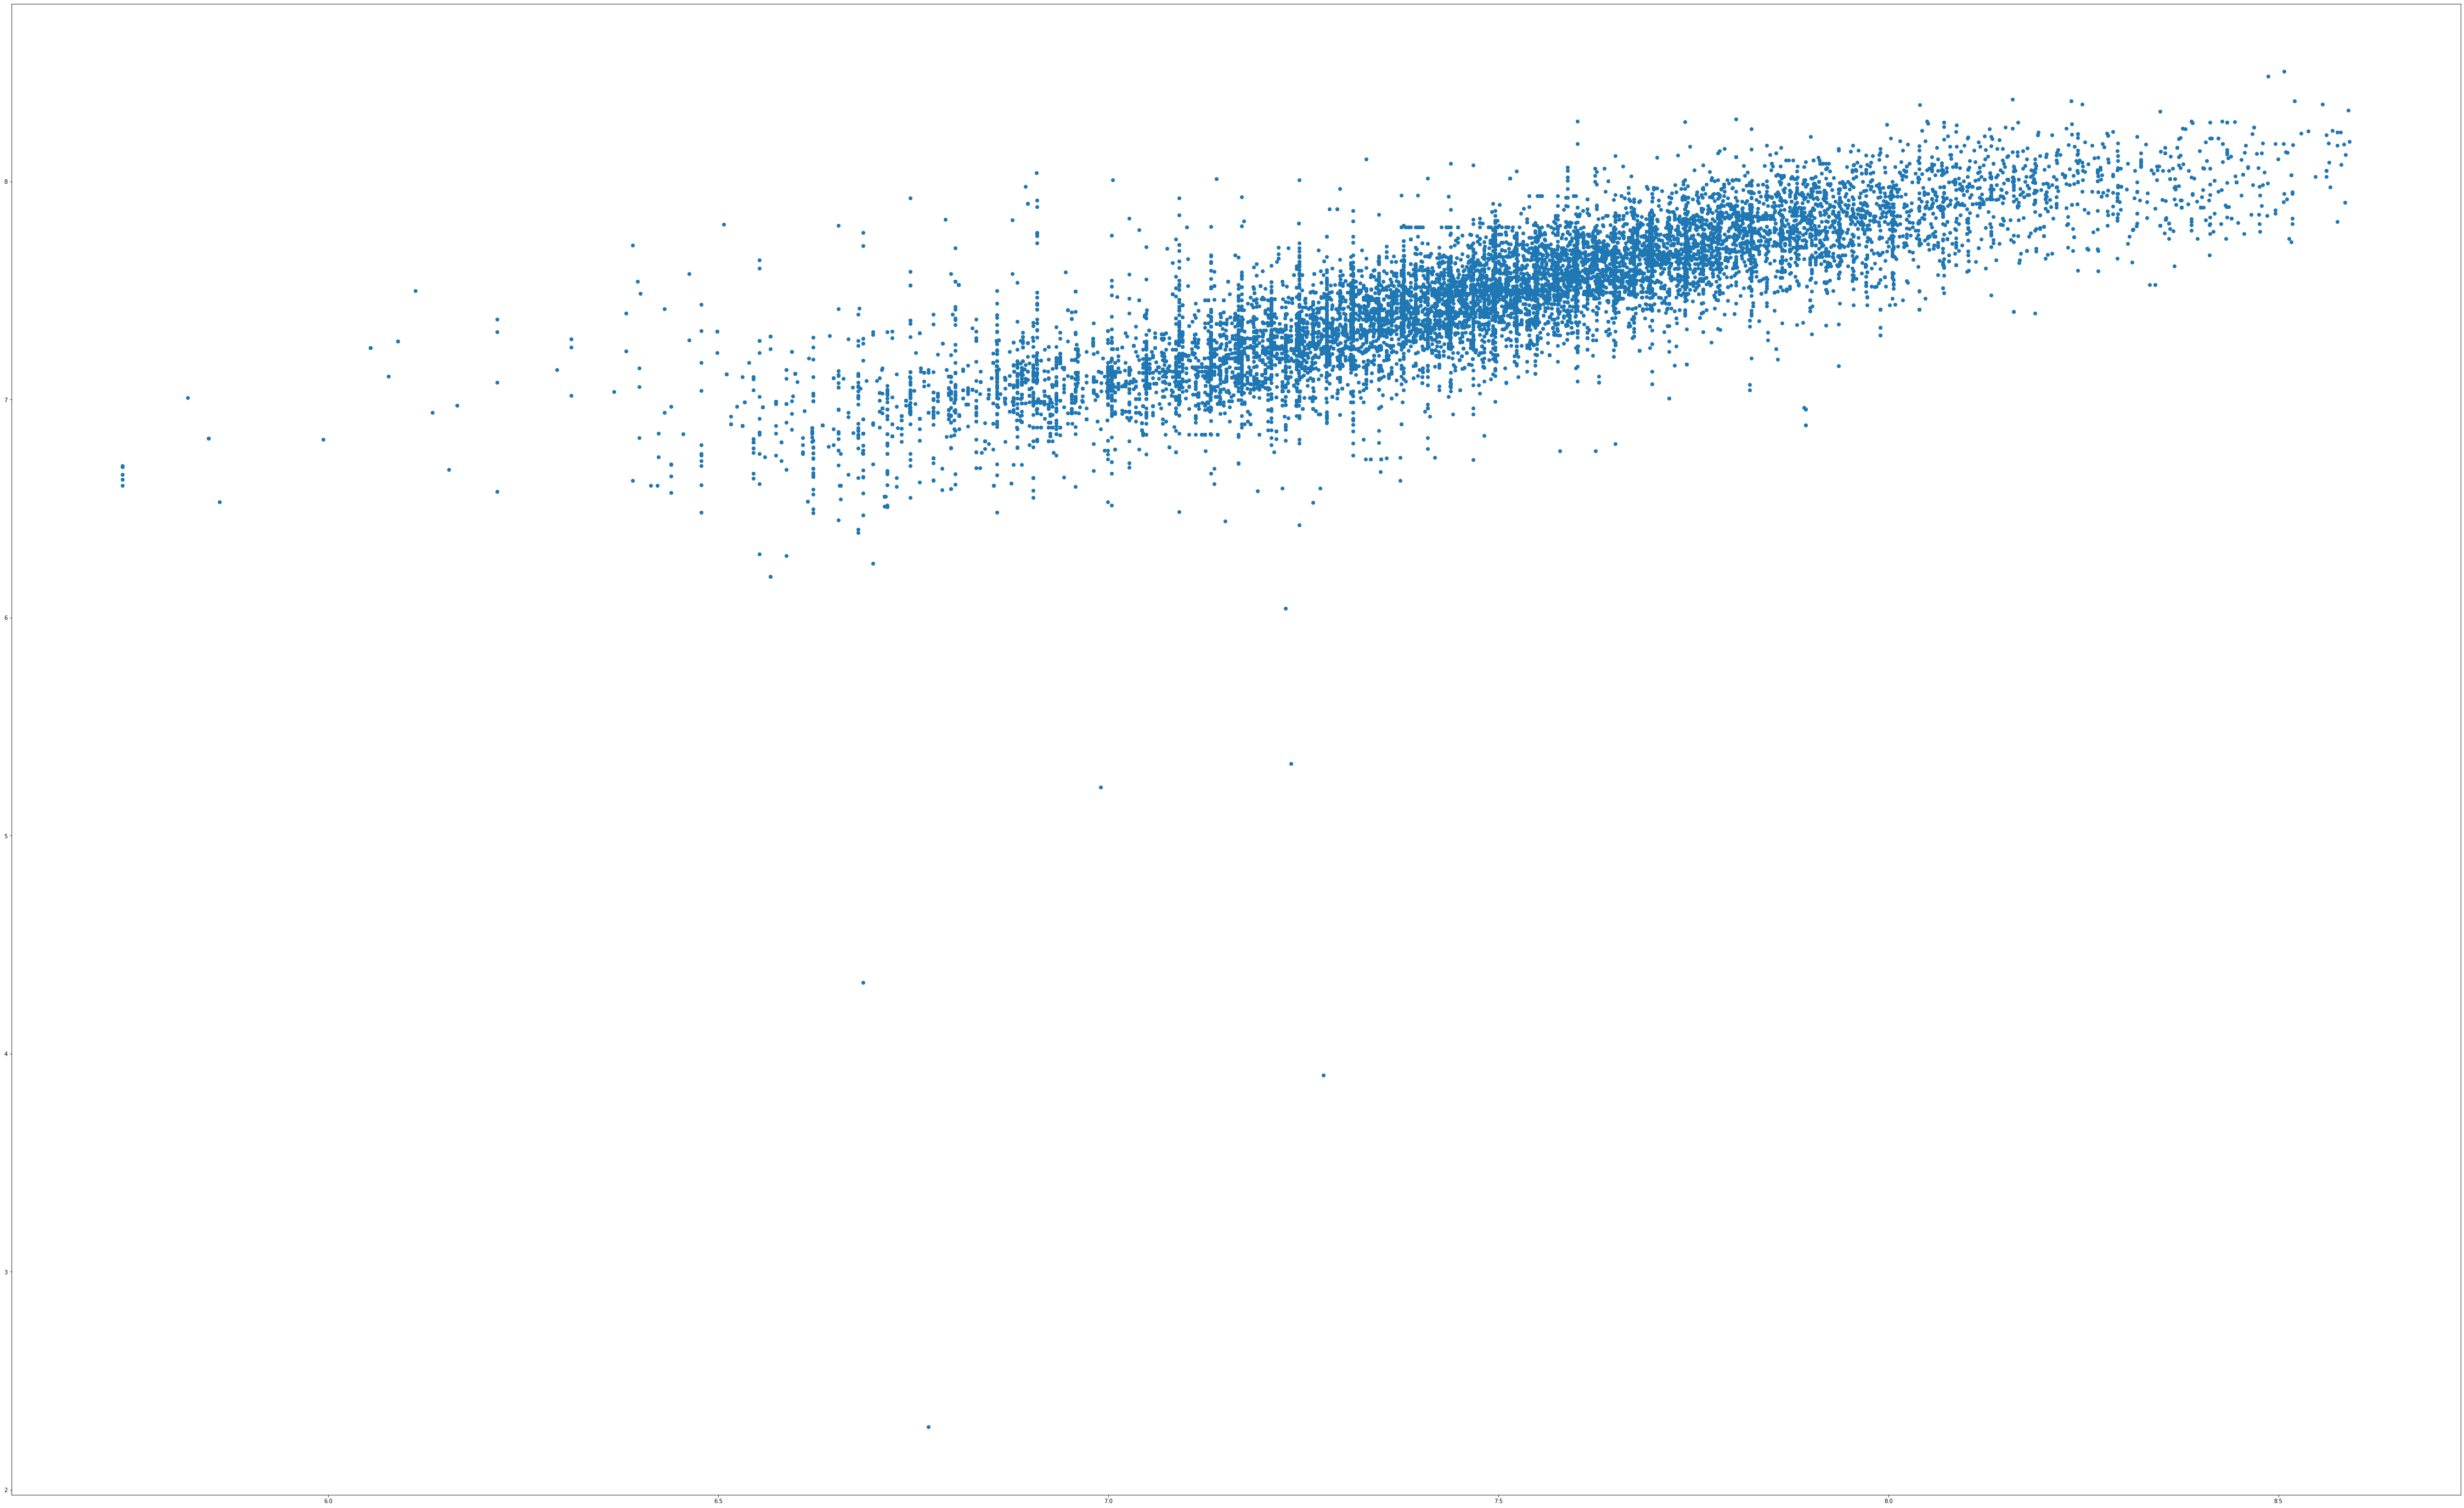

In [86]:
plt.scatter(y_train, yhat_train_lin)

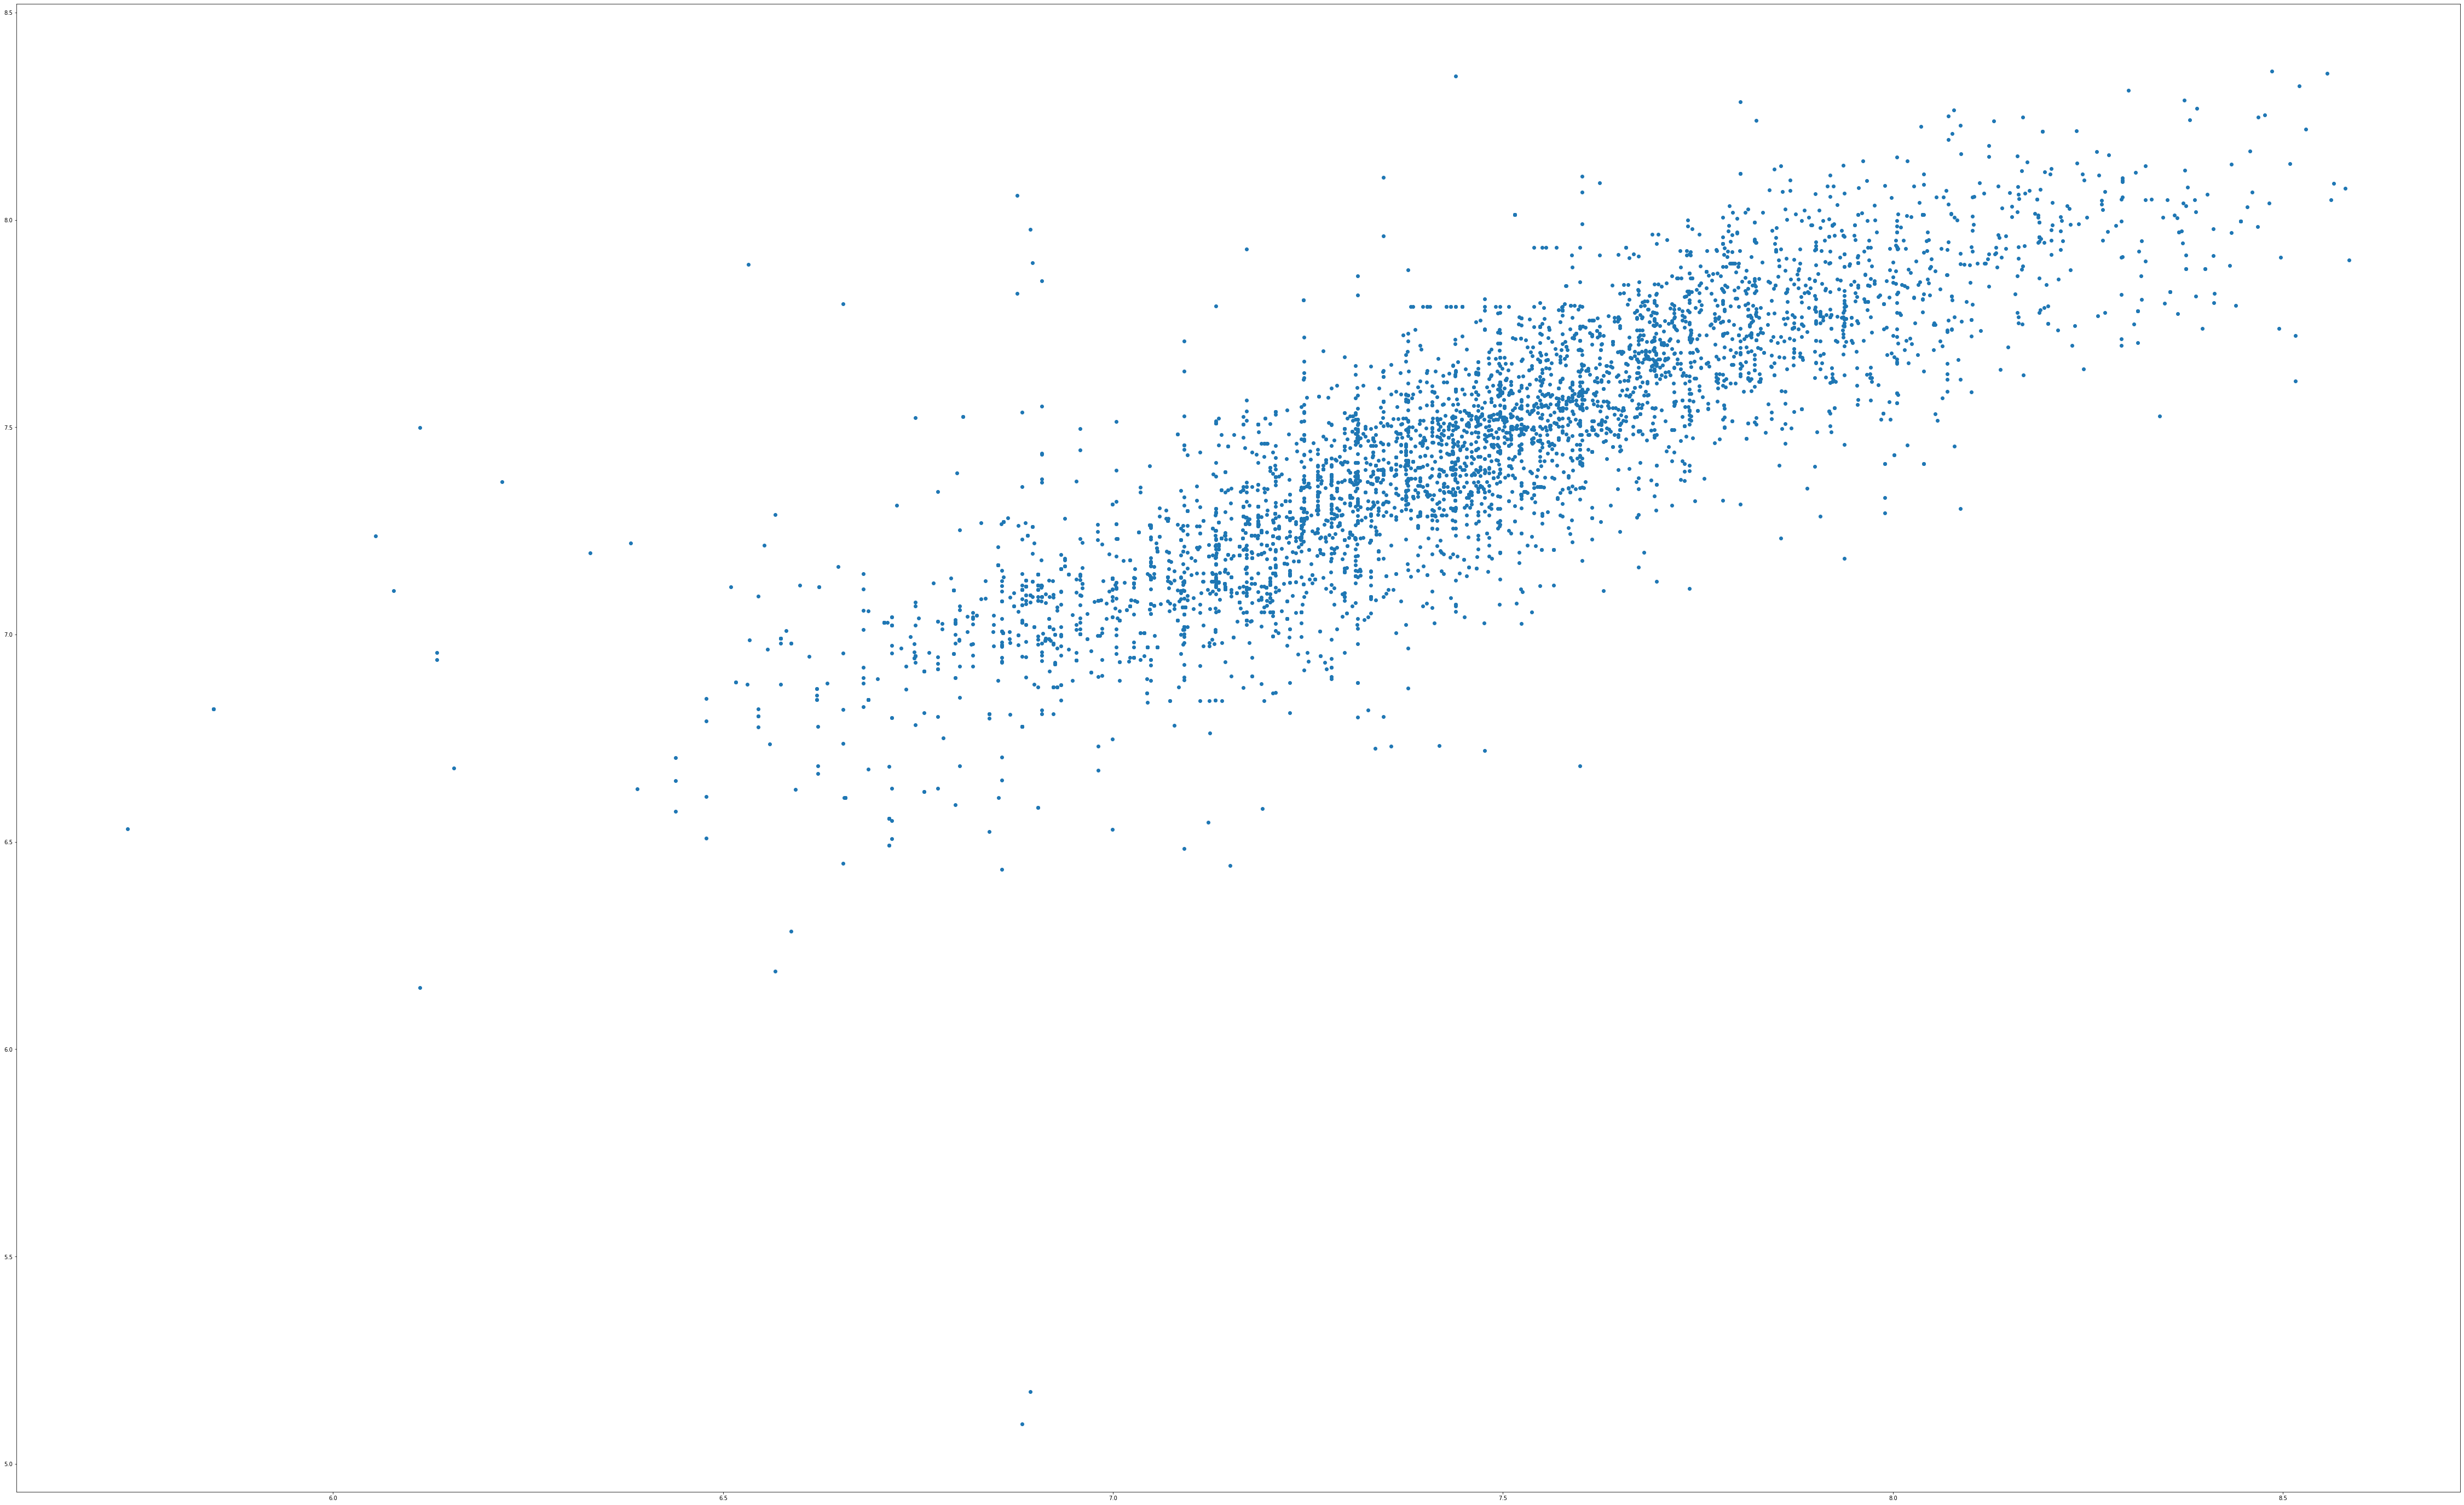

In [87]:
plt.scatter(y_val, yhat_val_lin)

### option 1-2 - ridge regression
it uses leave-one-out cross-validation to tune the regularization parameter

In [88]:
rreg = RidgeCV(alphas = np.logspace(-3,3,7)).fit(X_train, y_train)

In [89]:
rreg.score(X_train, y_train)

0.6922386455123358

In [90]:
yhat_train_rr = rreg.predict(X_train)
yhat_val_rr = rreg.predict(X_val)

In [91]:
rreg.get_params()

{'alpha_per_target': False,
 'alphas': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
 'cv': None,
 'fit_intercept': True,
 'gcv_mode': None,
 'normalize': 'deprecated',
 'scoring': None,
 'store_cv_values': False}

In [92]:
rreg.alpha_

0.1

In [93]:
printMetrics(y_train, yhat_train_rr)
print()
printMetrics(y_val, yhat_val_rr)

RMSE:  0.2045
MAE:  0.1479
MAPE:  0.02
R2:  0.6922

RMSE:  0.2035
MAE:  0.1493
MAPE:  0.0201
R2:  0.6922


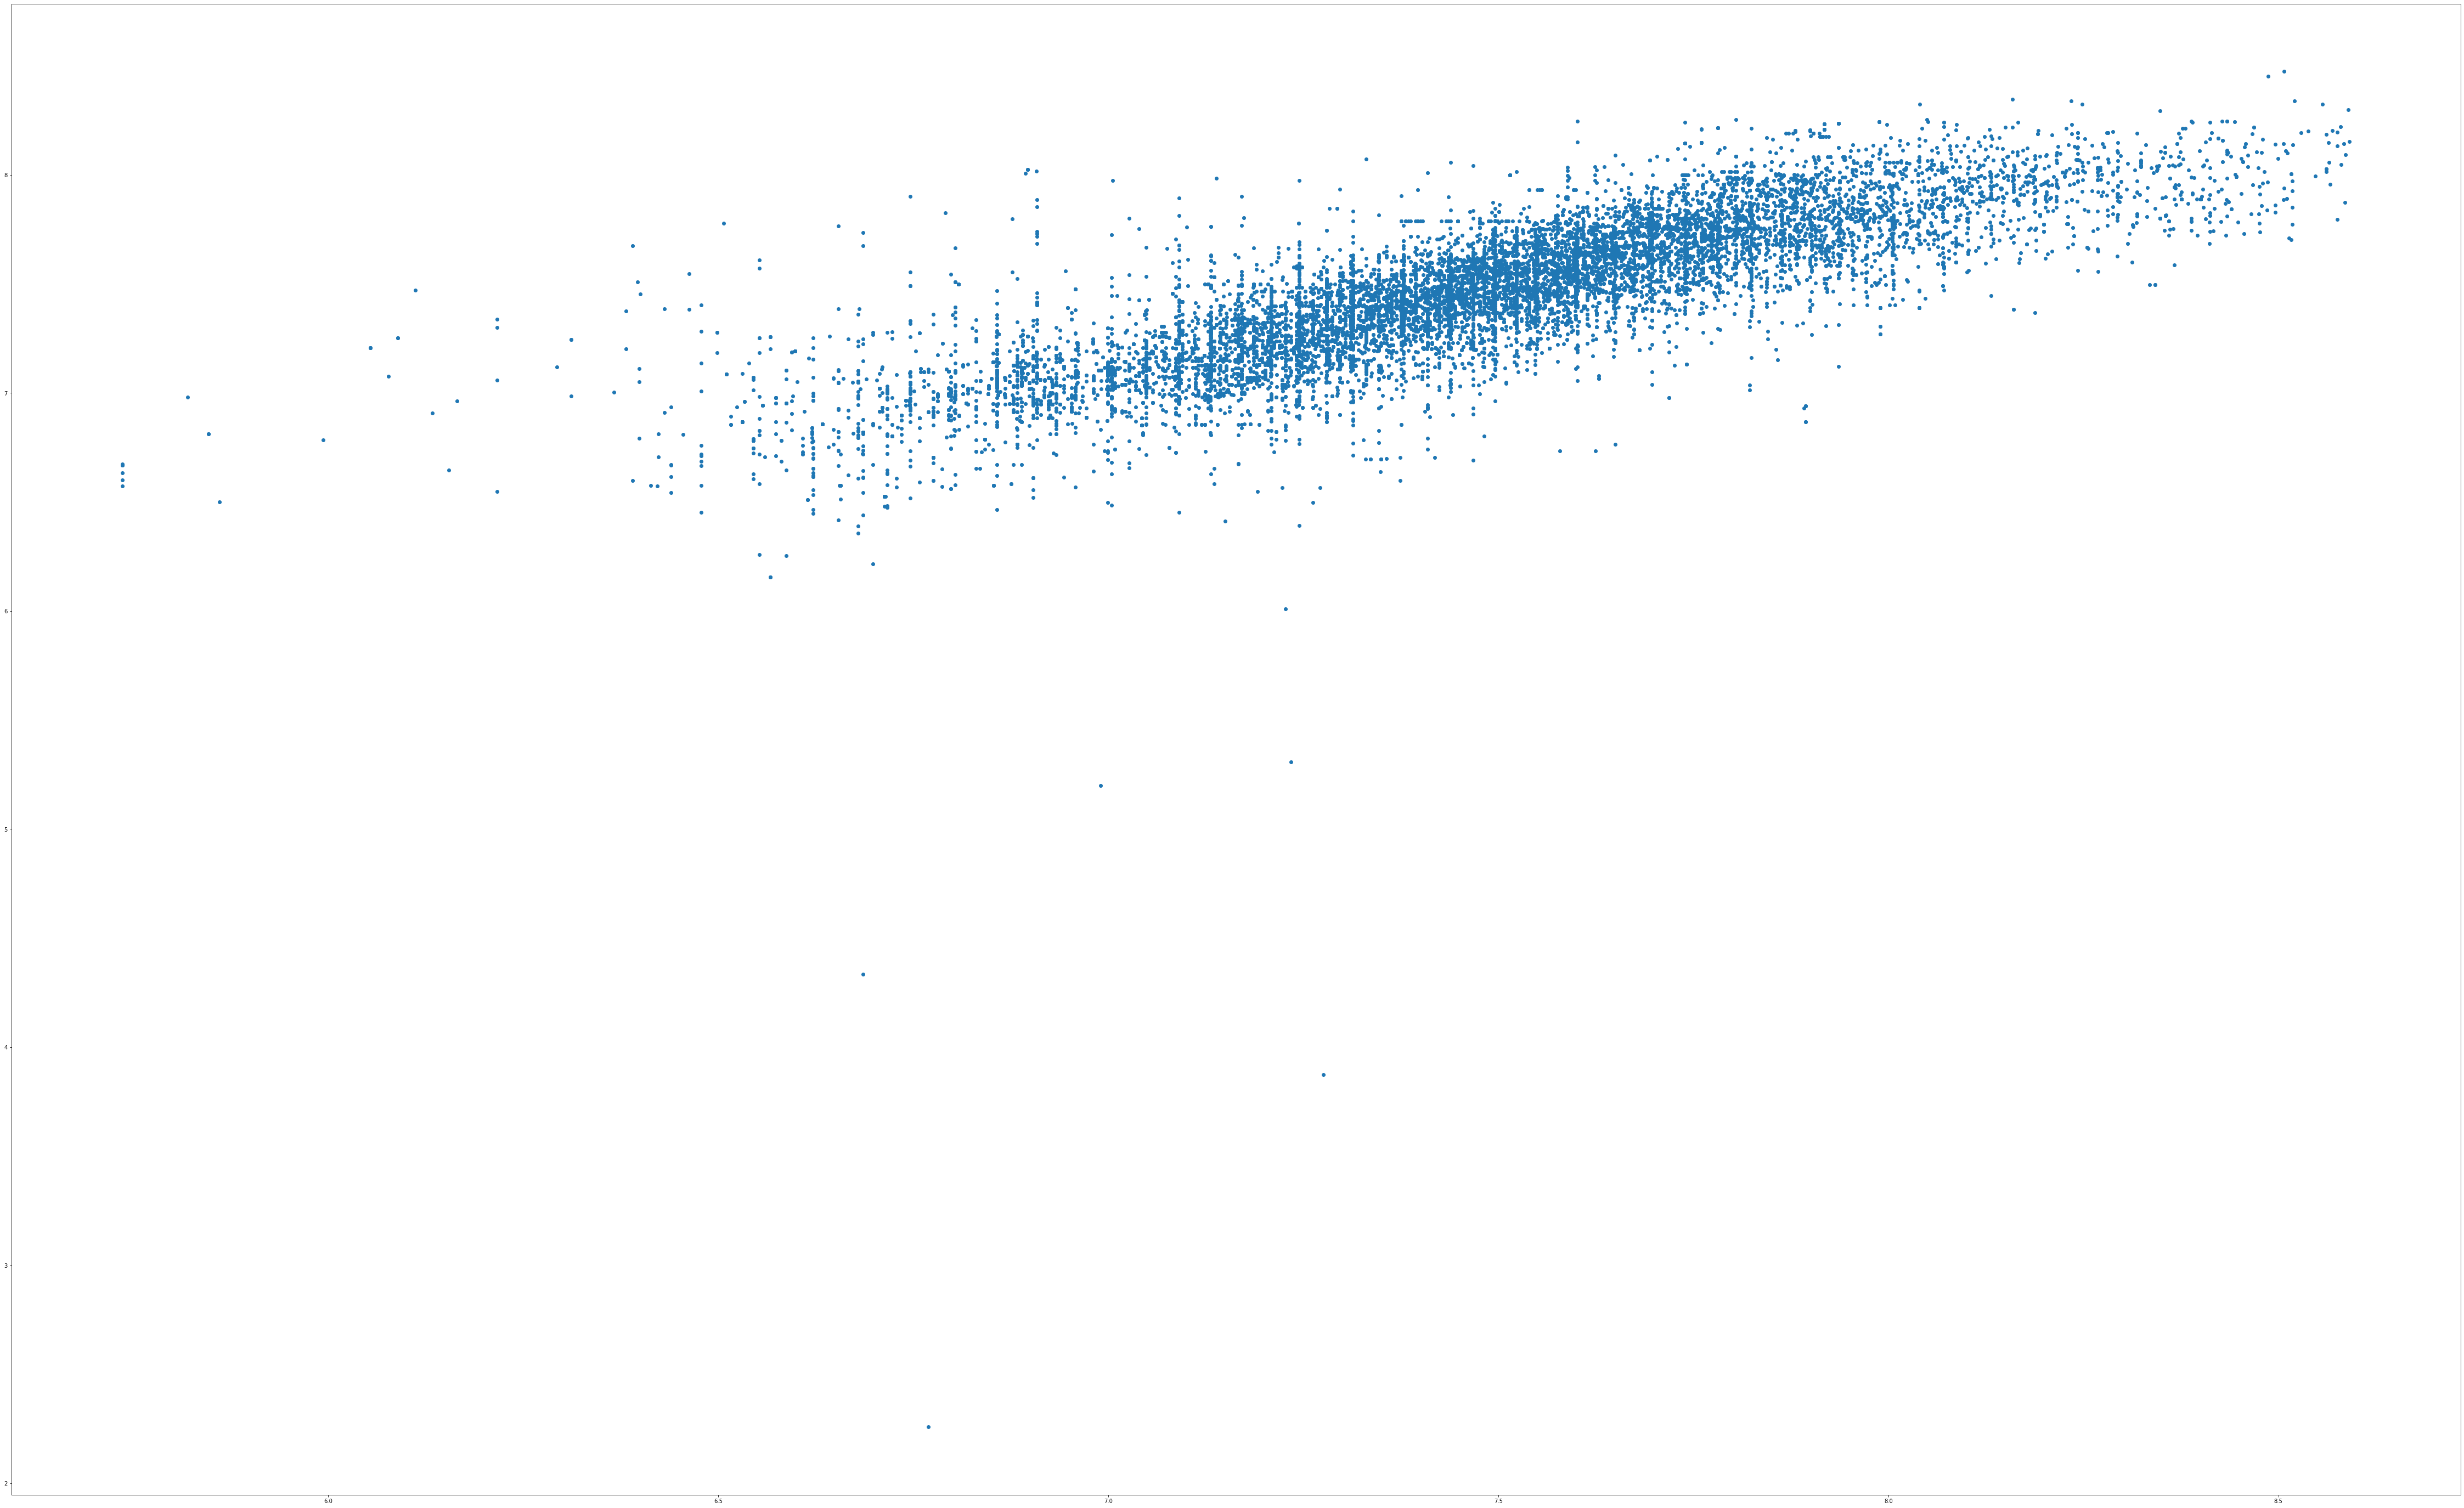

In [94]:
plt.scatter(y_train, yhat_train_rr)

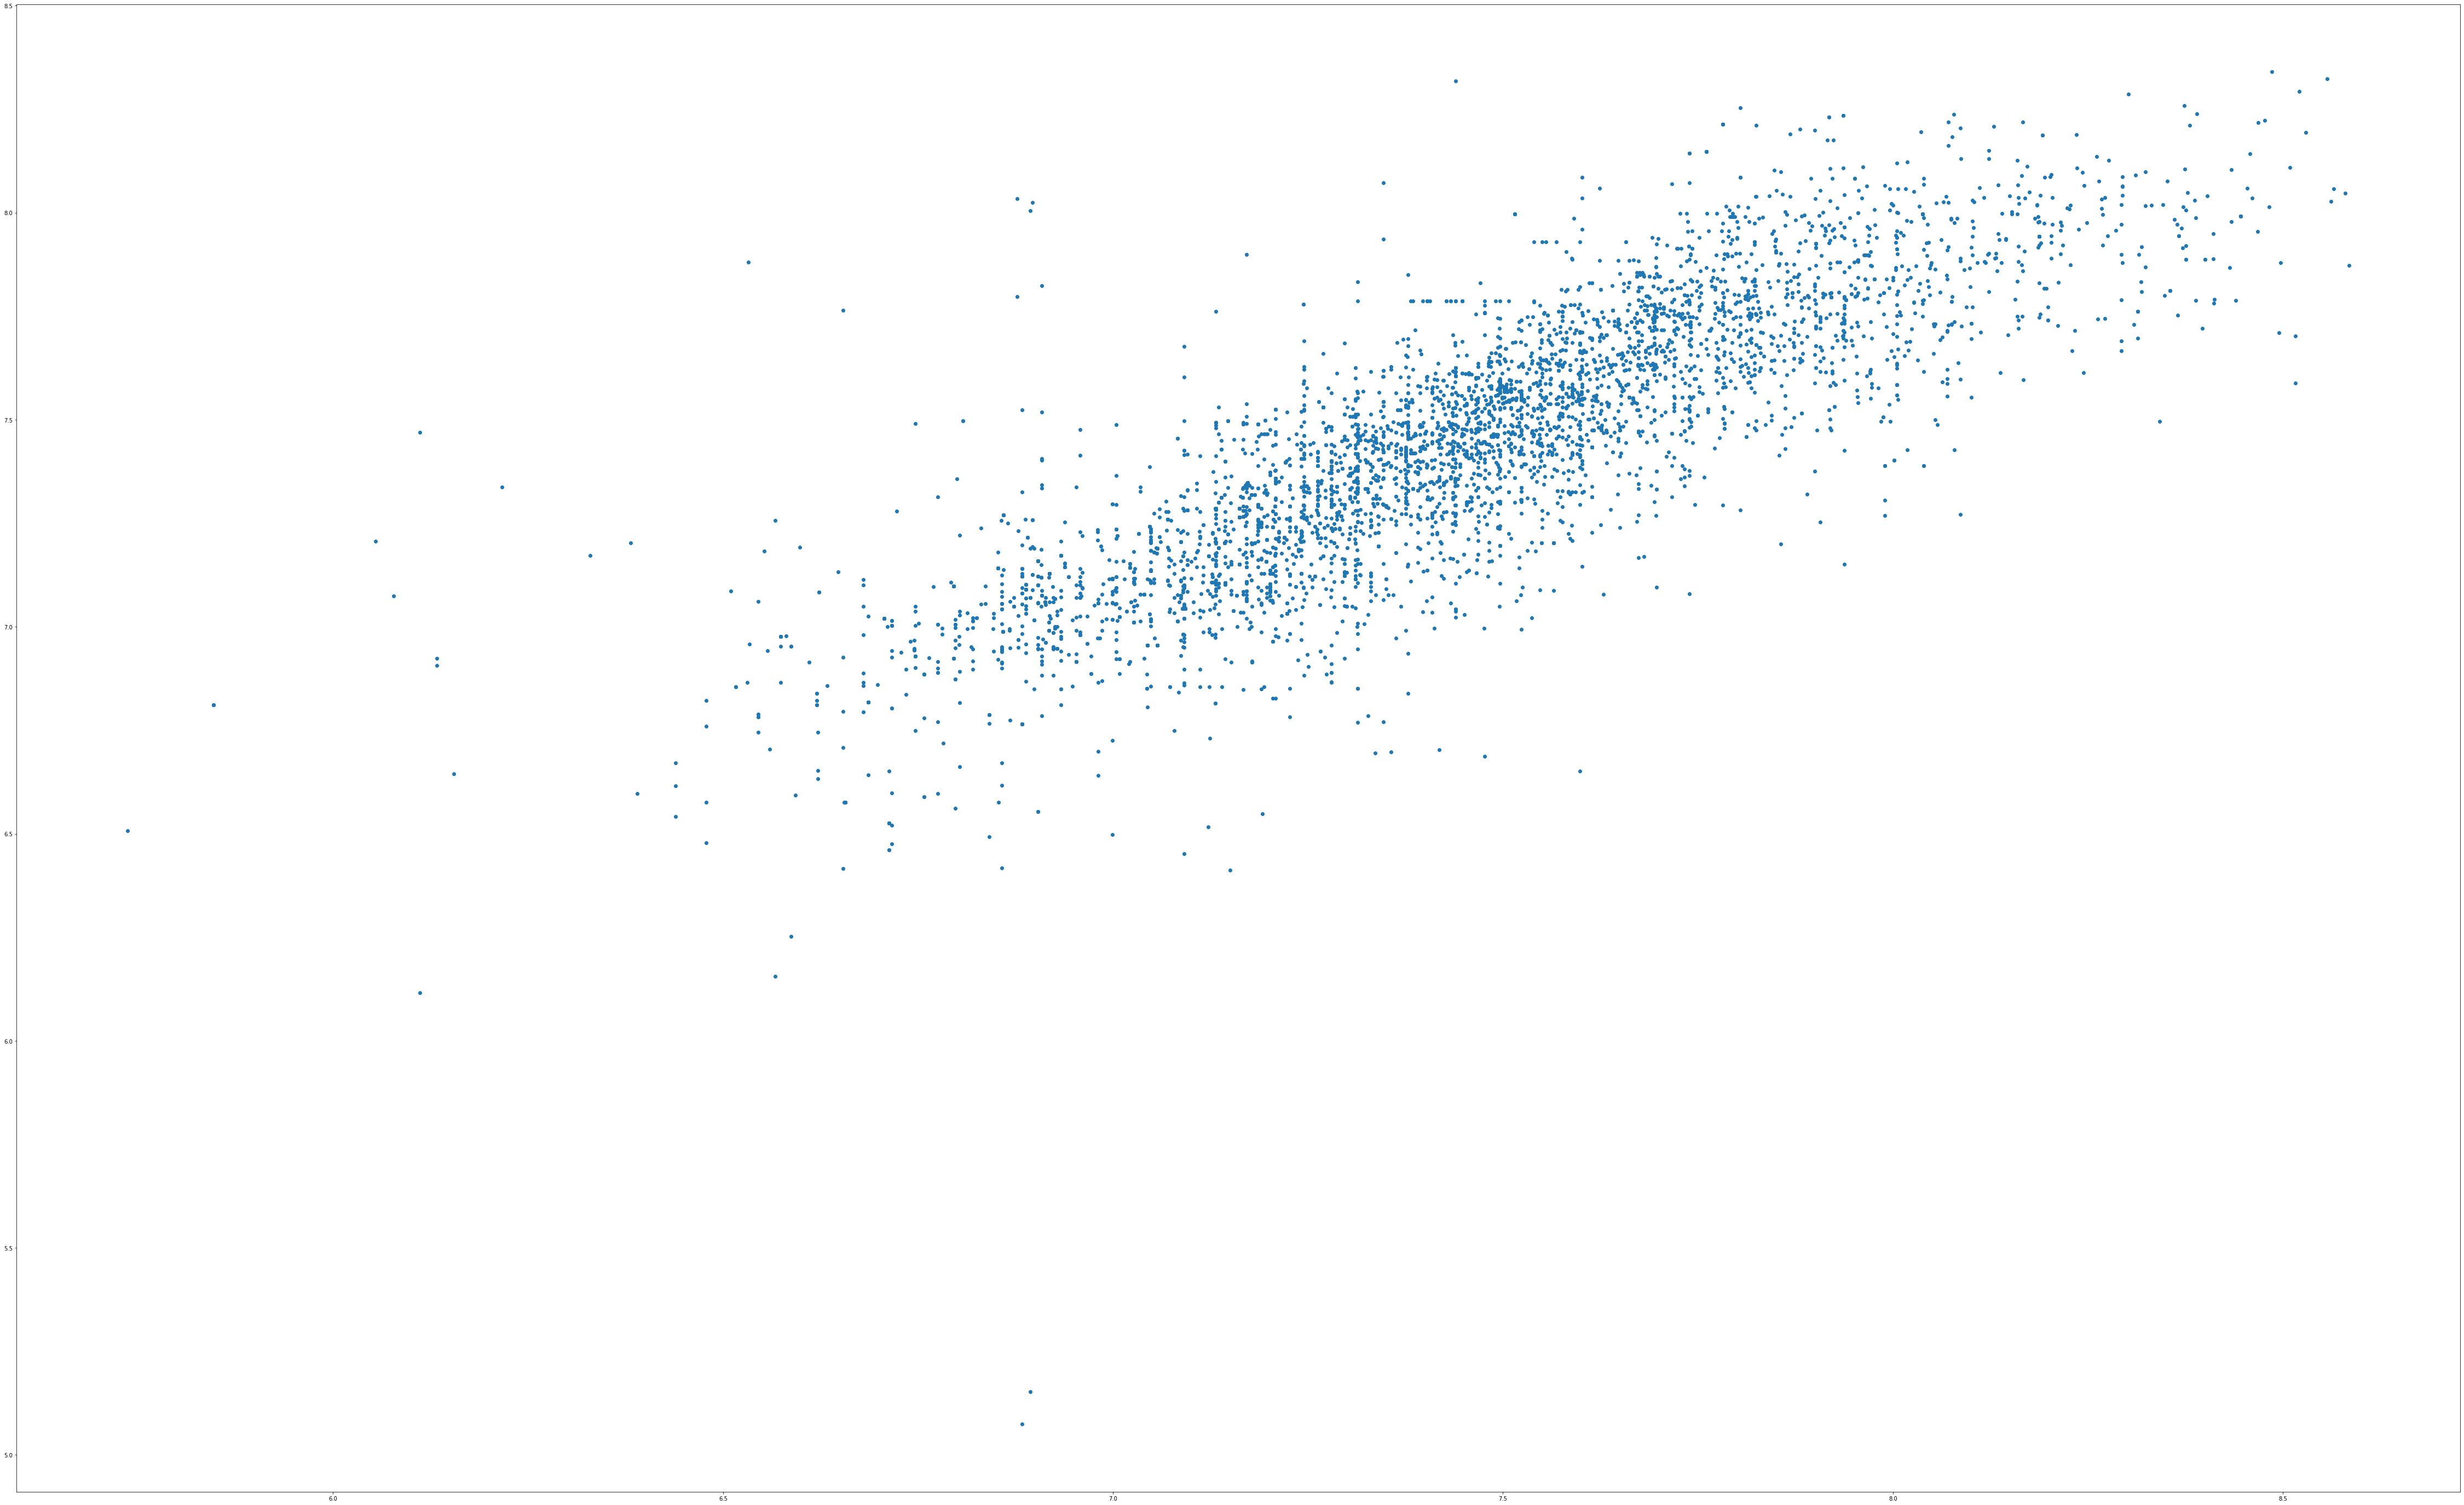

In [95]:
plt.scatter(y_val, yhat_val_rr)

### option 1-3 - lasso regression

In [96]:
lreg = LassoCV(alphas = np.logspace(-3,3,7)).fit(X_train, y_train)

c:\Users\adria\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 344.13024714321057, tolerance: 0.20289875213242473
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\adria\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 335.6079961820847, tolerance: 0.20475986901044185
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\adria\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 323.3558593729551, tolerance: 0.20044009724898176
  model = cd_fast.enet_coordinate_descent_gram(


In [97]:
lreg.score(X_train, y_train)

0.6971945680671148

In [98]:
yhat_train_lr = lreg.predict(X_train)
yhat_val_lr = lreg.predict(X_val)

In [99]:
lreg.get_params()

{'alphas': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
 'copy_X': True,
 'cv': None,
 'eps': 0.001,
 'fit_intercept': True,
 'max_iter': 1000,
 'n_alphas': 100,
 'n_jobs': None,
 'normalize': 'deprecated',
 'positive': False,
 'precompute': 'auto',
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'verbose': False}

In [100]:
lreg.alpha_

0.001

In [101]:
printMetrics(y_train, yhat_train_lr)
print()
printMetrics(y_val, yhat_val_lr)

RMSE:  0.2028
MAE:  0.1435
MAPE:  0.0194
R2:  0.6972

RMSE:  0.2003
MAE:  0.1454
MAPE:  0.0196
R2:  0.702


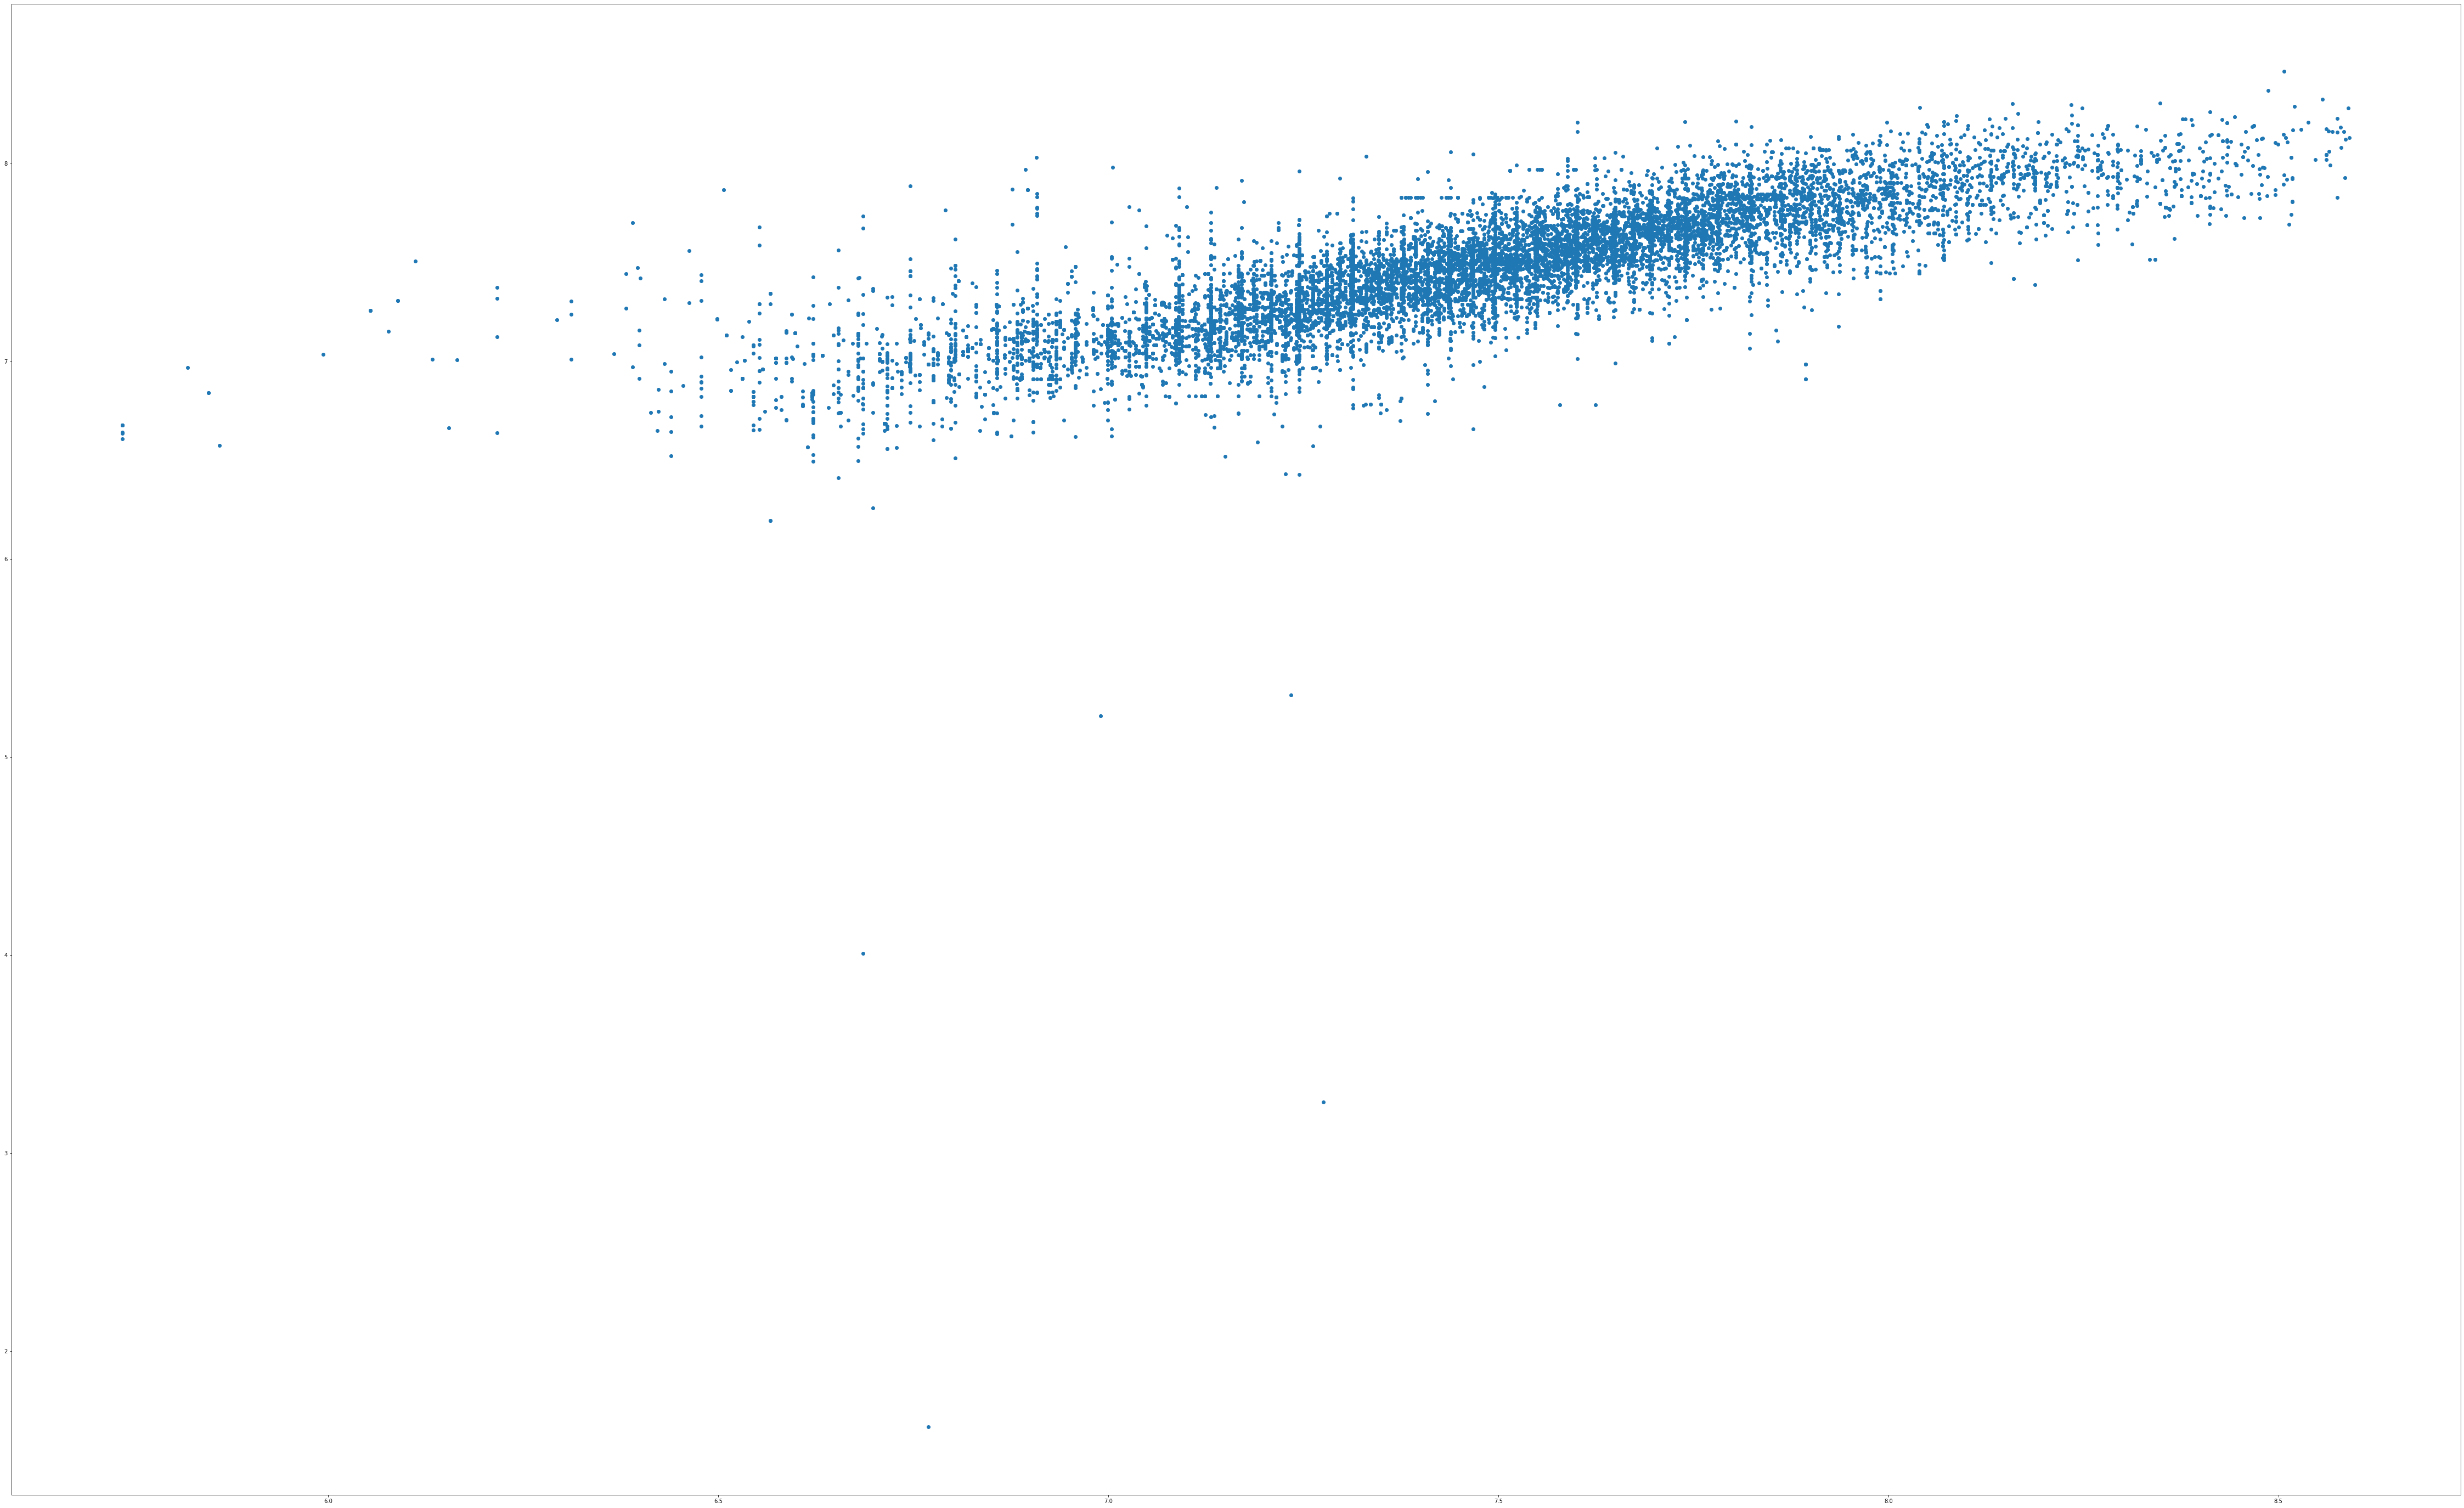

In [102]:
plt.scatter(y_train, yhat_train_lr)

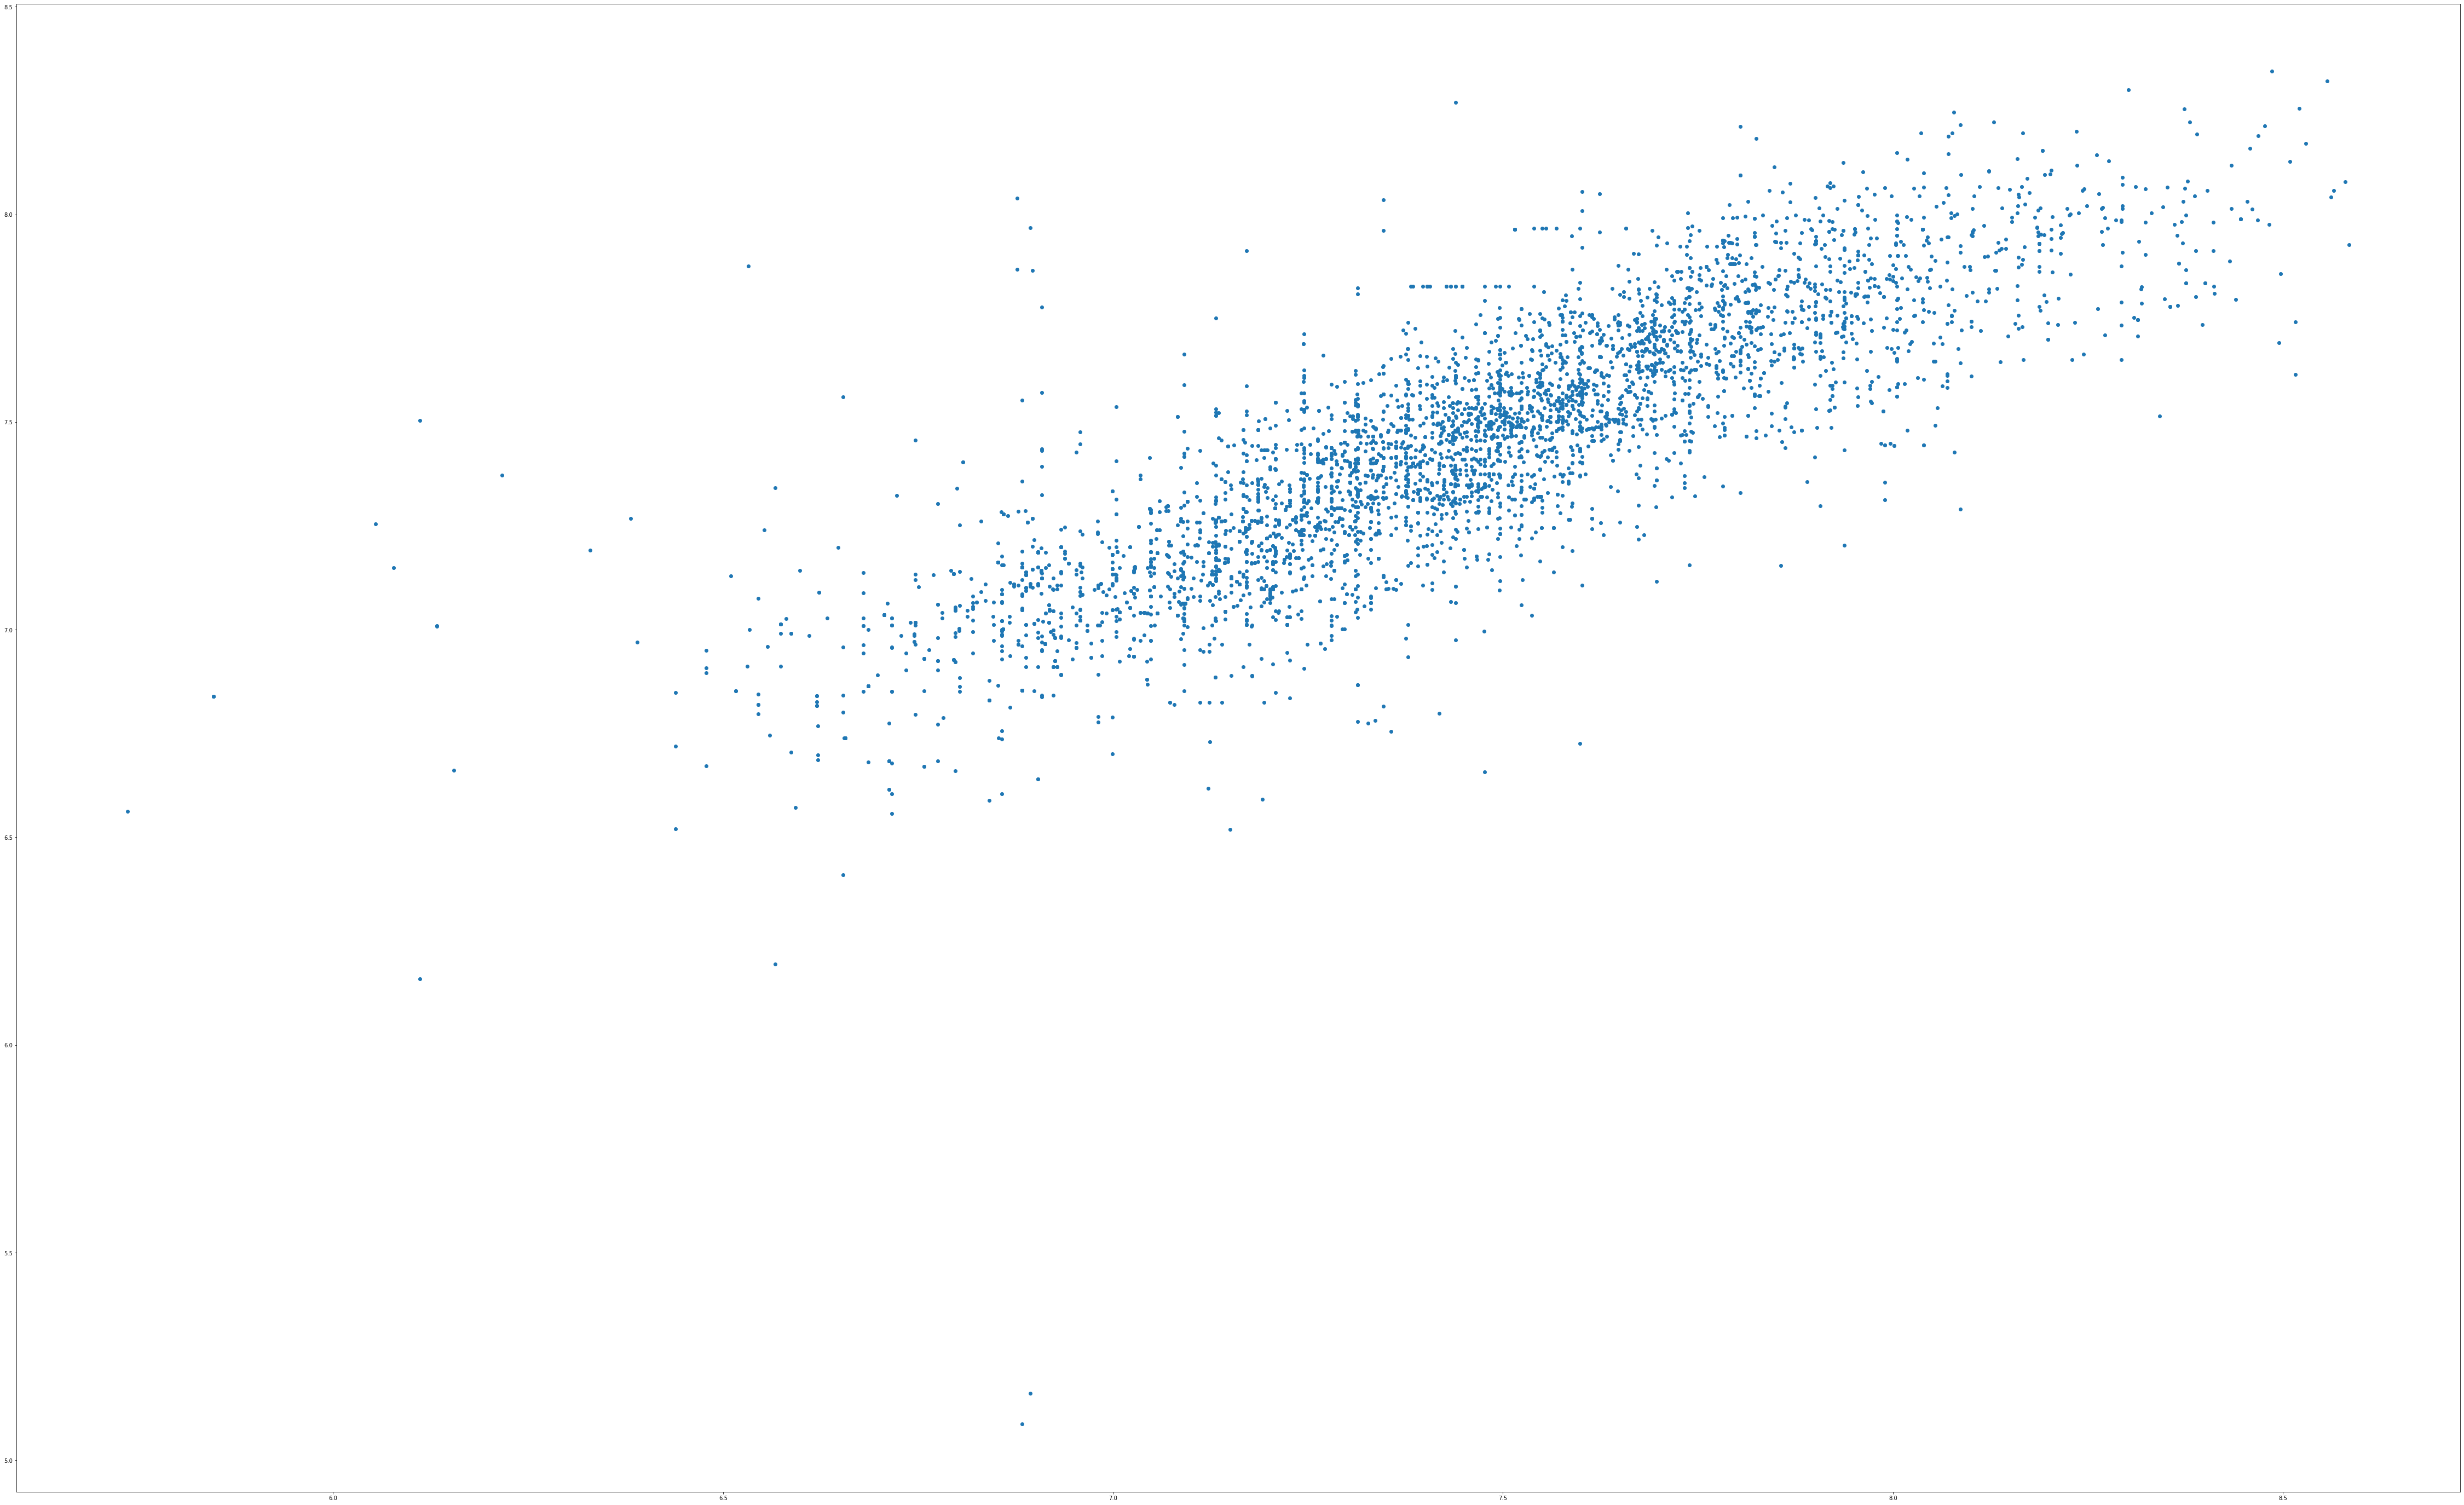

In [103]:
plt.scatter(y_val, yhat_val_lr)

### option 2 - random forest
random forest from scikit-learn library, with the default parameters

In [104]:
rf = RandomForestRegressor(oob_score=True).fit(X_train, y_train)

In [105]:
yhat_train_rf = rf.predict(X_train)
yhat_val_rf = rf.predict(X_val)

In [106]:
printMetrics(y_train, yhat_train_rf)
print()
printMetrics(y_val, yhat_val_rf)

RMSE:  0.0406
MAE:  0.0206
MAPE:  0.0028
R2:  0.9879

RMSE:  0.0709
MAE:  0.0314
MAPE:  0.0042
R2:  0.9627


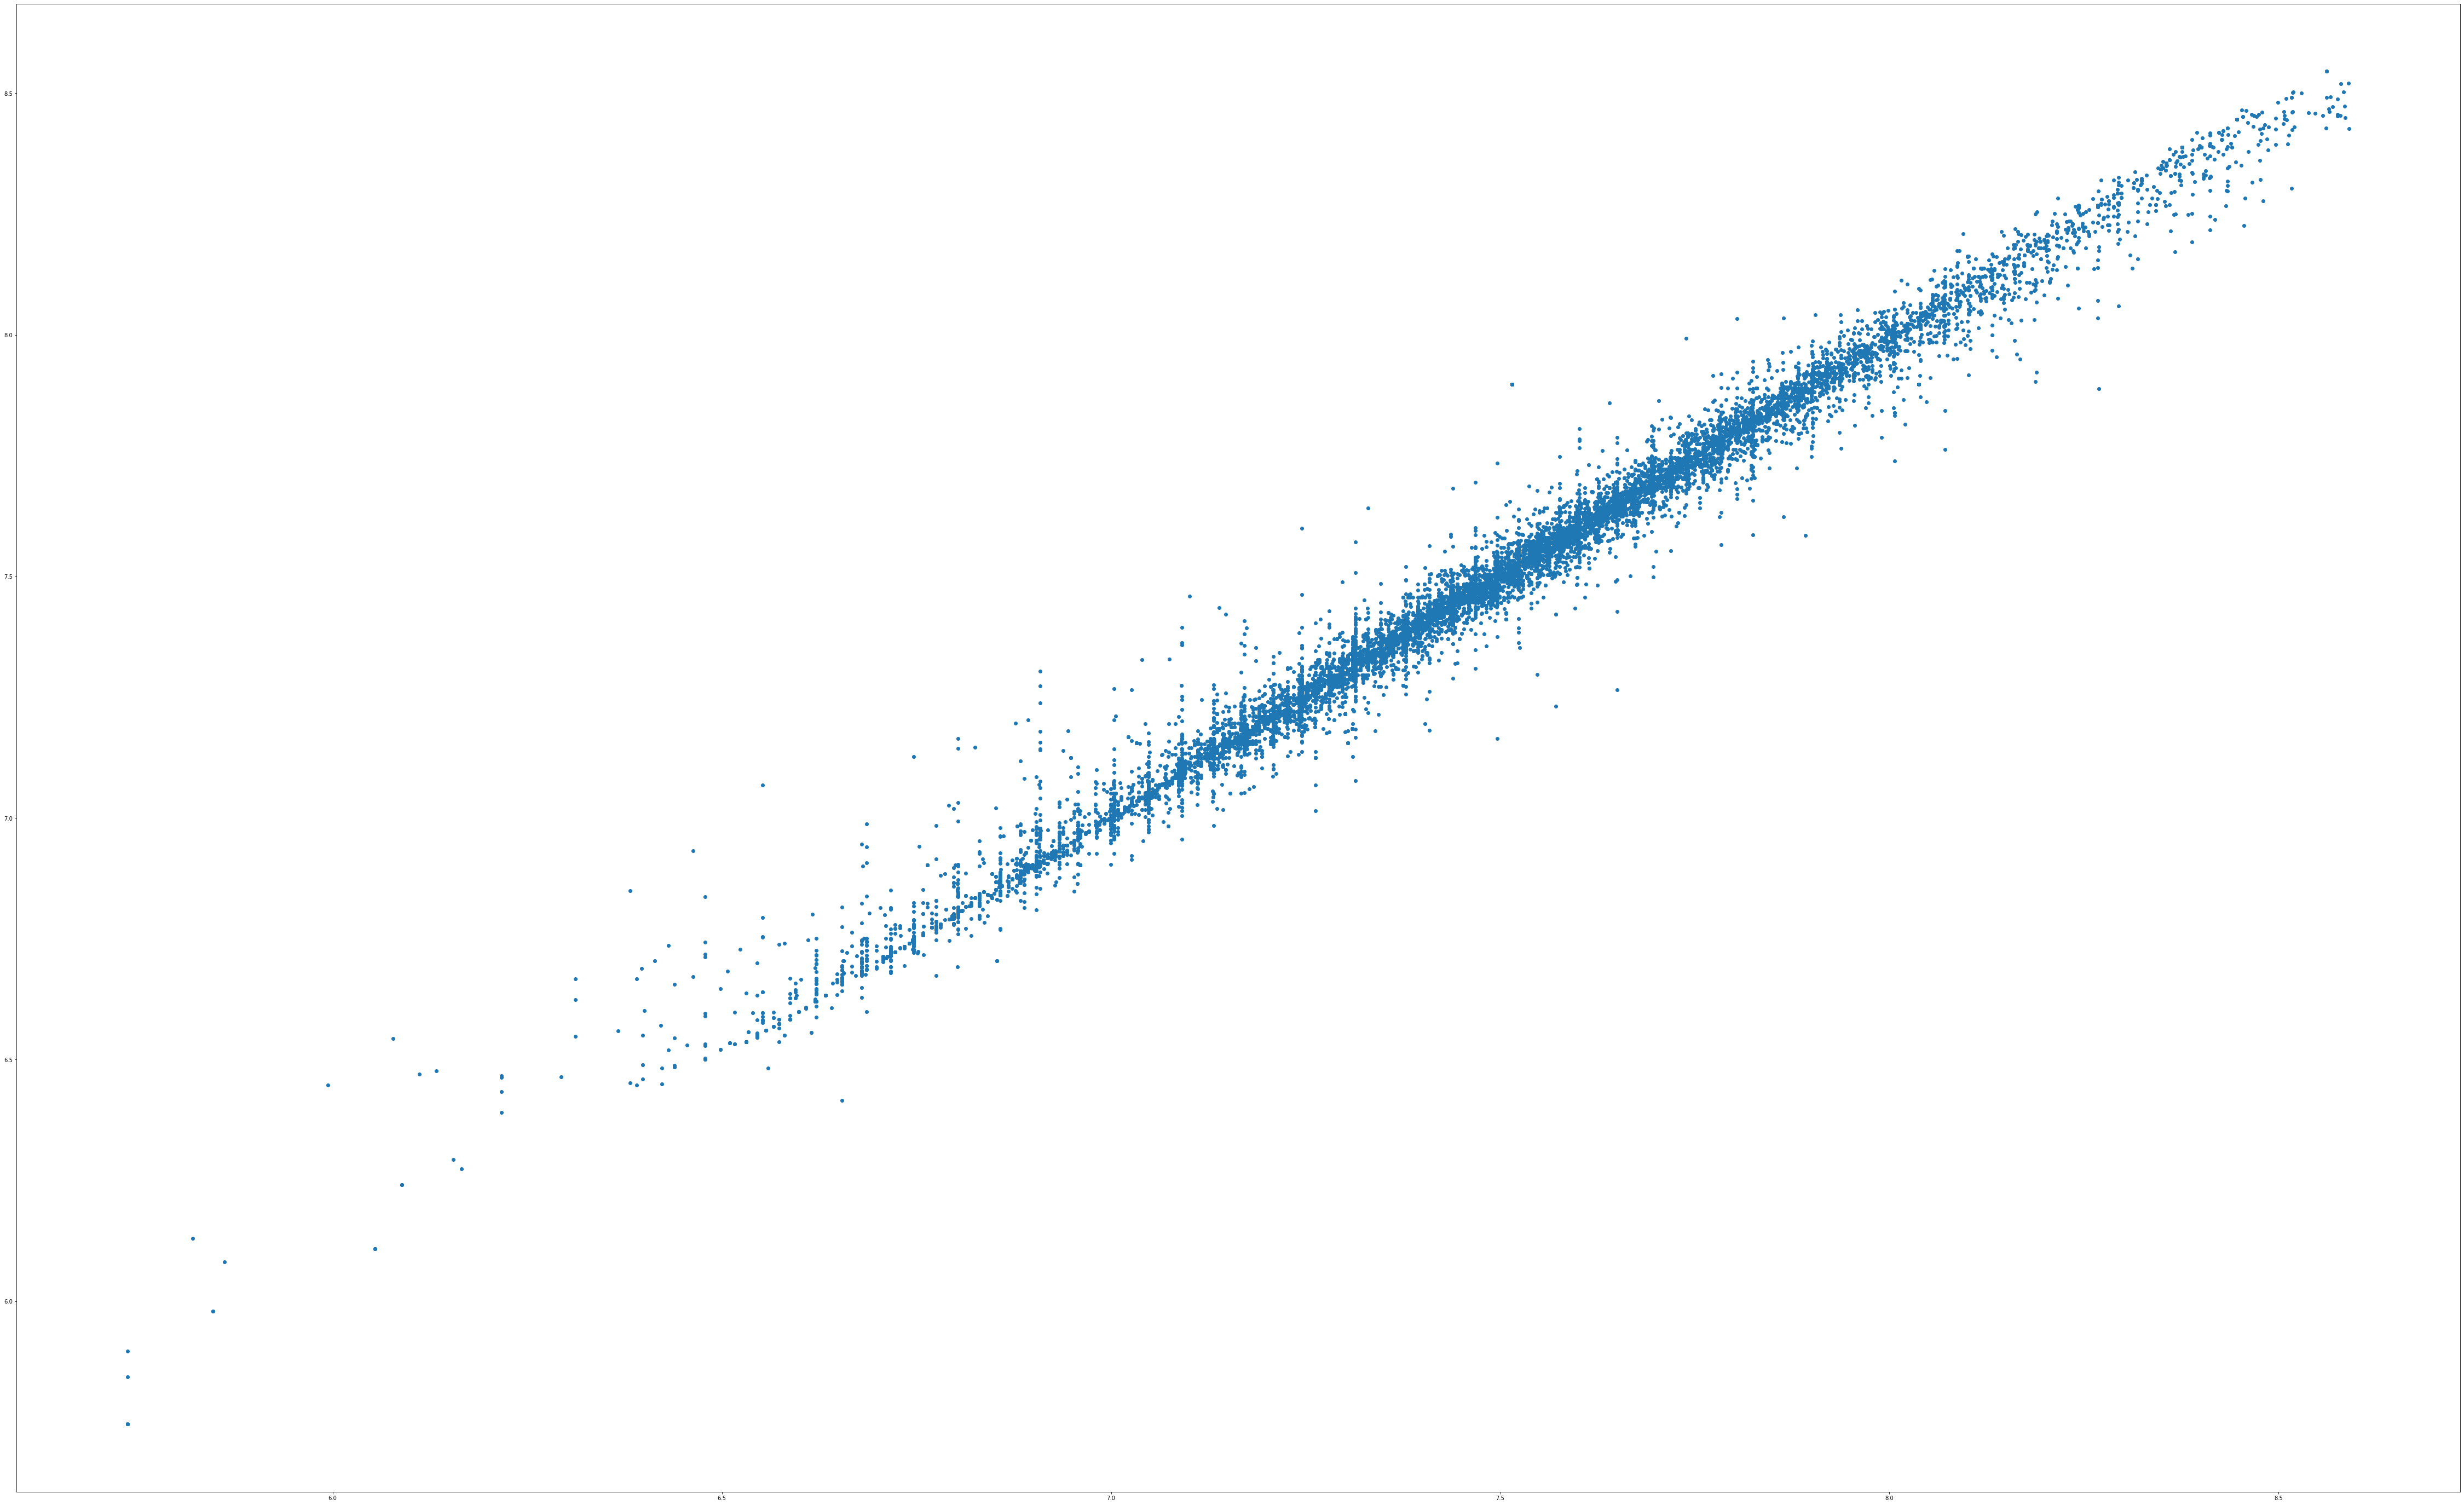

In [107]:
plt.scatter(y_train, yhat_train_rf)

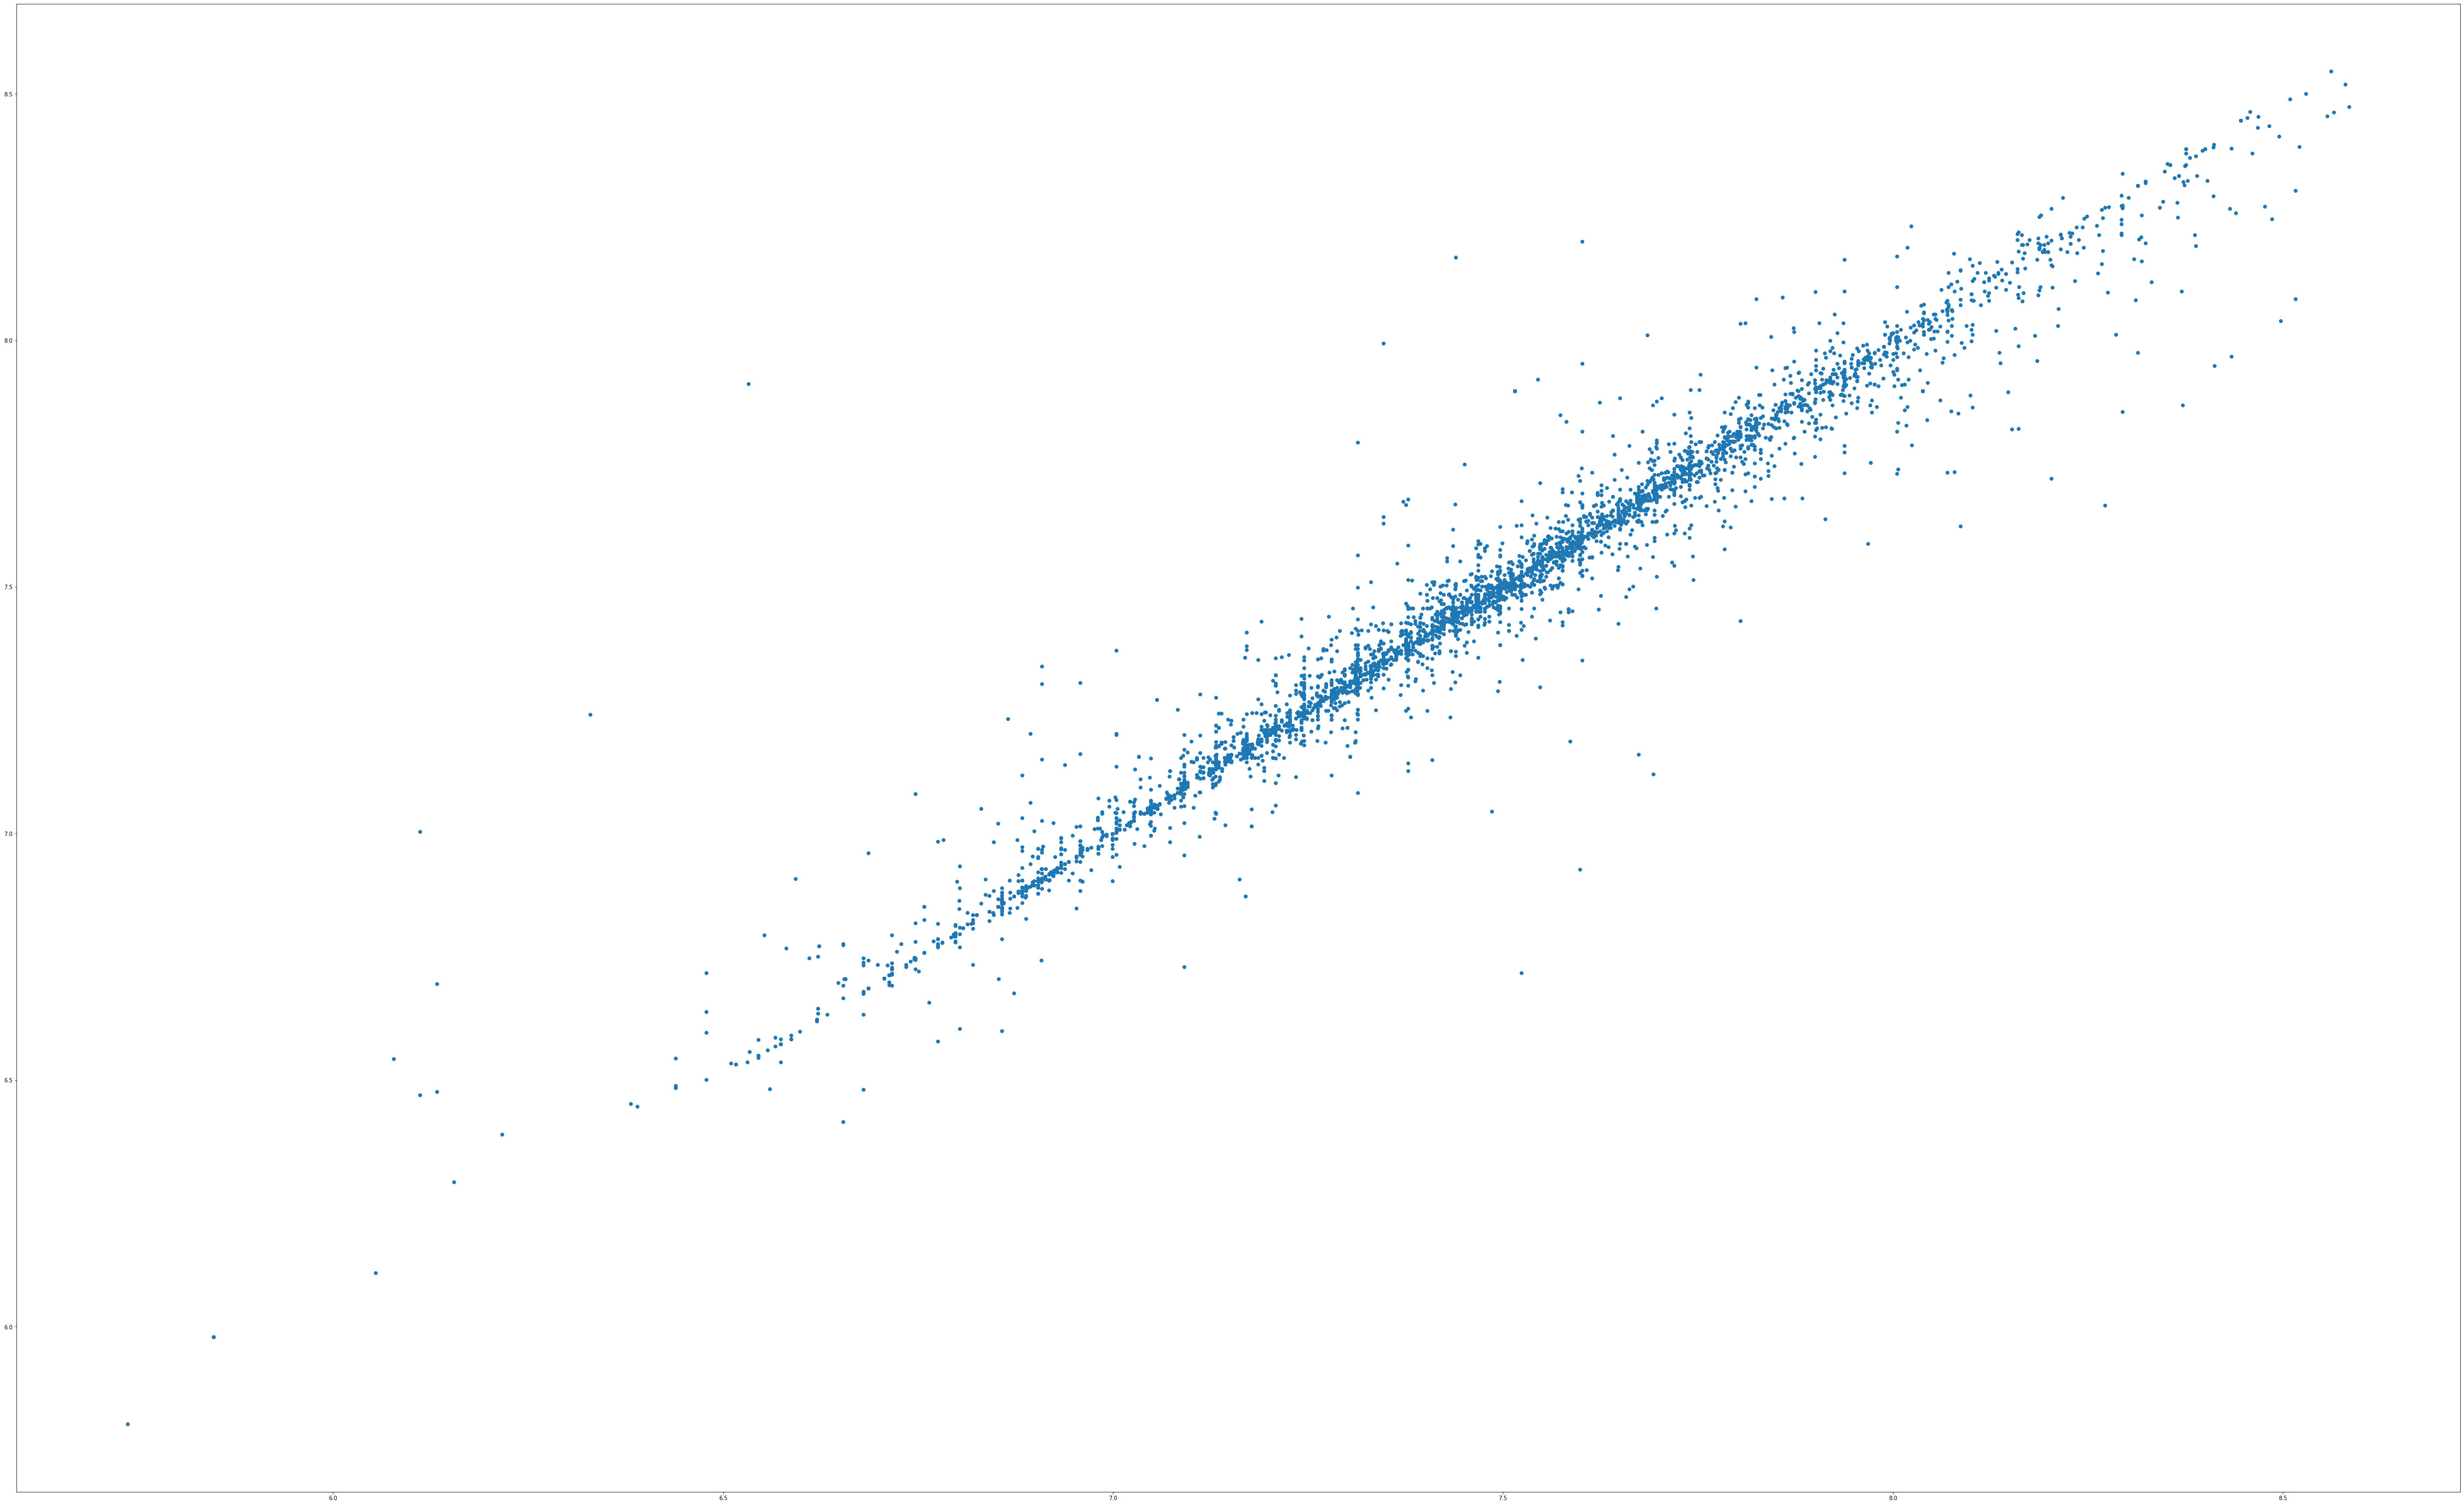

In [108]:
plt.scatter(y_val, yhat_val_rf)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

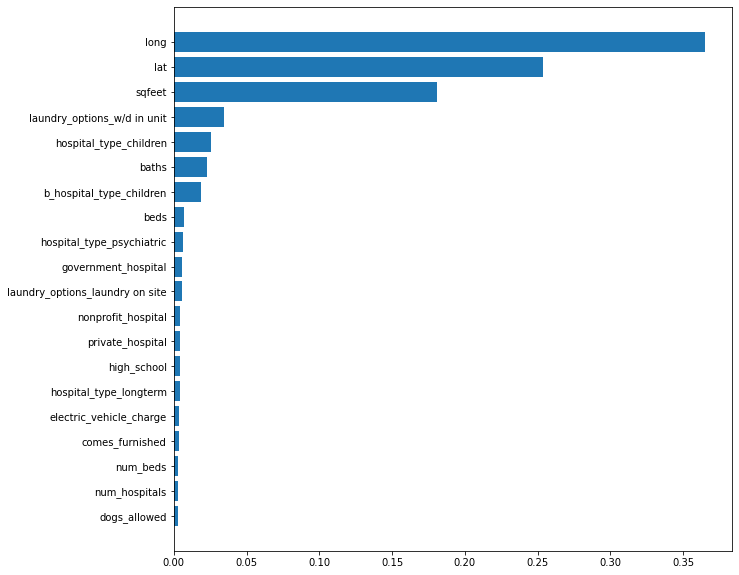

In [109]:
# top 20 feature importance
sorted_idx = rf.feature_importances_.argsort()
plt.figure(figsize=(10,10))
plt.barh(rf.feature_names_in_[sorted_idx][-20:], rf.feature_importances_[sorted_idx][-20:])
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

In [110]:
from sklearn.tree import plot_tree

[Text(0.5, 0.875, 'lat <= 34.474\nsquared_error = 0.137\nsamples = 11919\nvalue = 7.428'),
 Text(0.25, 0.625, 'sqfeet <= 6.929\nsquared_error = 0.092\nsamples = 5203\nvalue = 7.592'),
 Text(0.125, 0.375, 'long <= -116.977\nsquared_error = 0.072\nsamples = 3889\nvalue = 7.507'),
 Text(0.0625, 0.125, '\n  (...)  \n'),
 Text(0.1875, 0.125, '\n  (...)  \n'),
 Text(0.375, 0.375, 'long <= -116.346\nsquared_error = 0.069\nsamples = 1314\nvalue = 7.839'),
 Text(0.3125, 0.125, '\n  (...)  \n'),
 Text(0.4375, 0.125, '\n  (...)  \n'),
 Text(0.75, 0.625, 'long <= -121.848\nsquared_error = 0.136\nsamples = 6716\nvalue = 7.301'),
 Text(0.625, 0.375, 'lat <= 38.889\nsquared_error = 0.153\nsamples = 1168\nvalue = 7.781'),
 Text(0.5625, 0.125, '\n  (...)  \n'),
 Text(0.6875, 0.125, '\n  (...)  \n'),
 Text(0.875, 0.375, 'sqfeet <= 6.919\nsquared_error = 0.075\nsamples = 5548\nvalue = 7.201'),
 Text(0.8125, 0.125, '\n  (...)  \n'),
 Text(0.9375, 0.125, '\n  (...)  \n')]

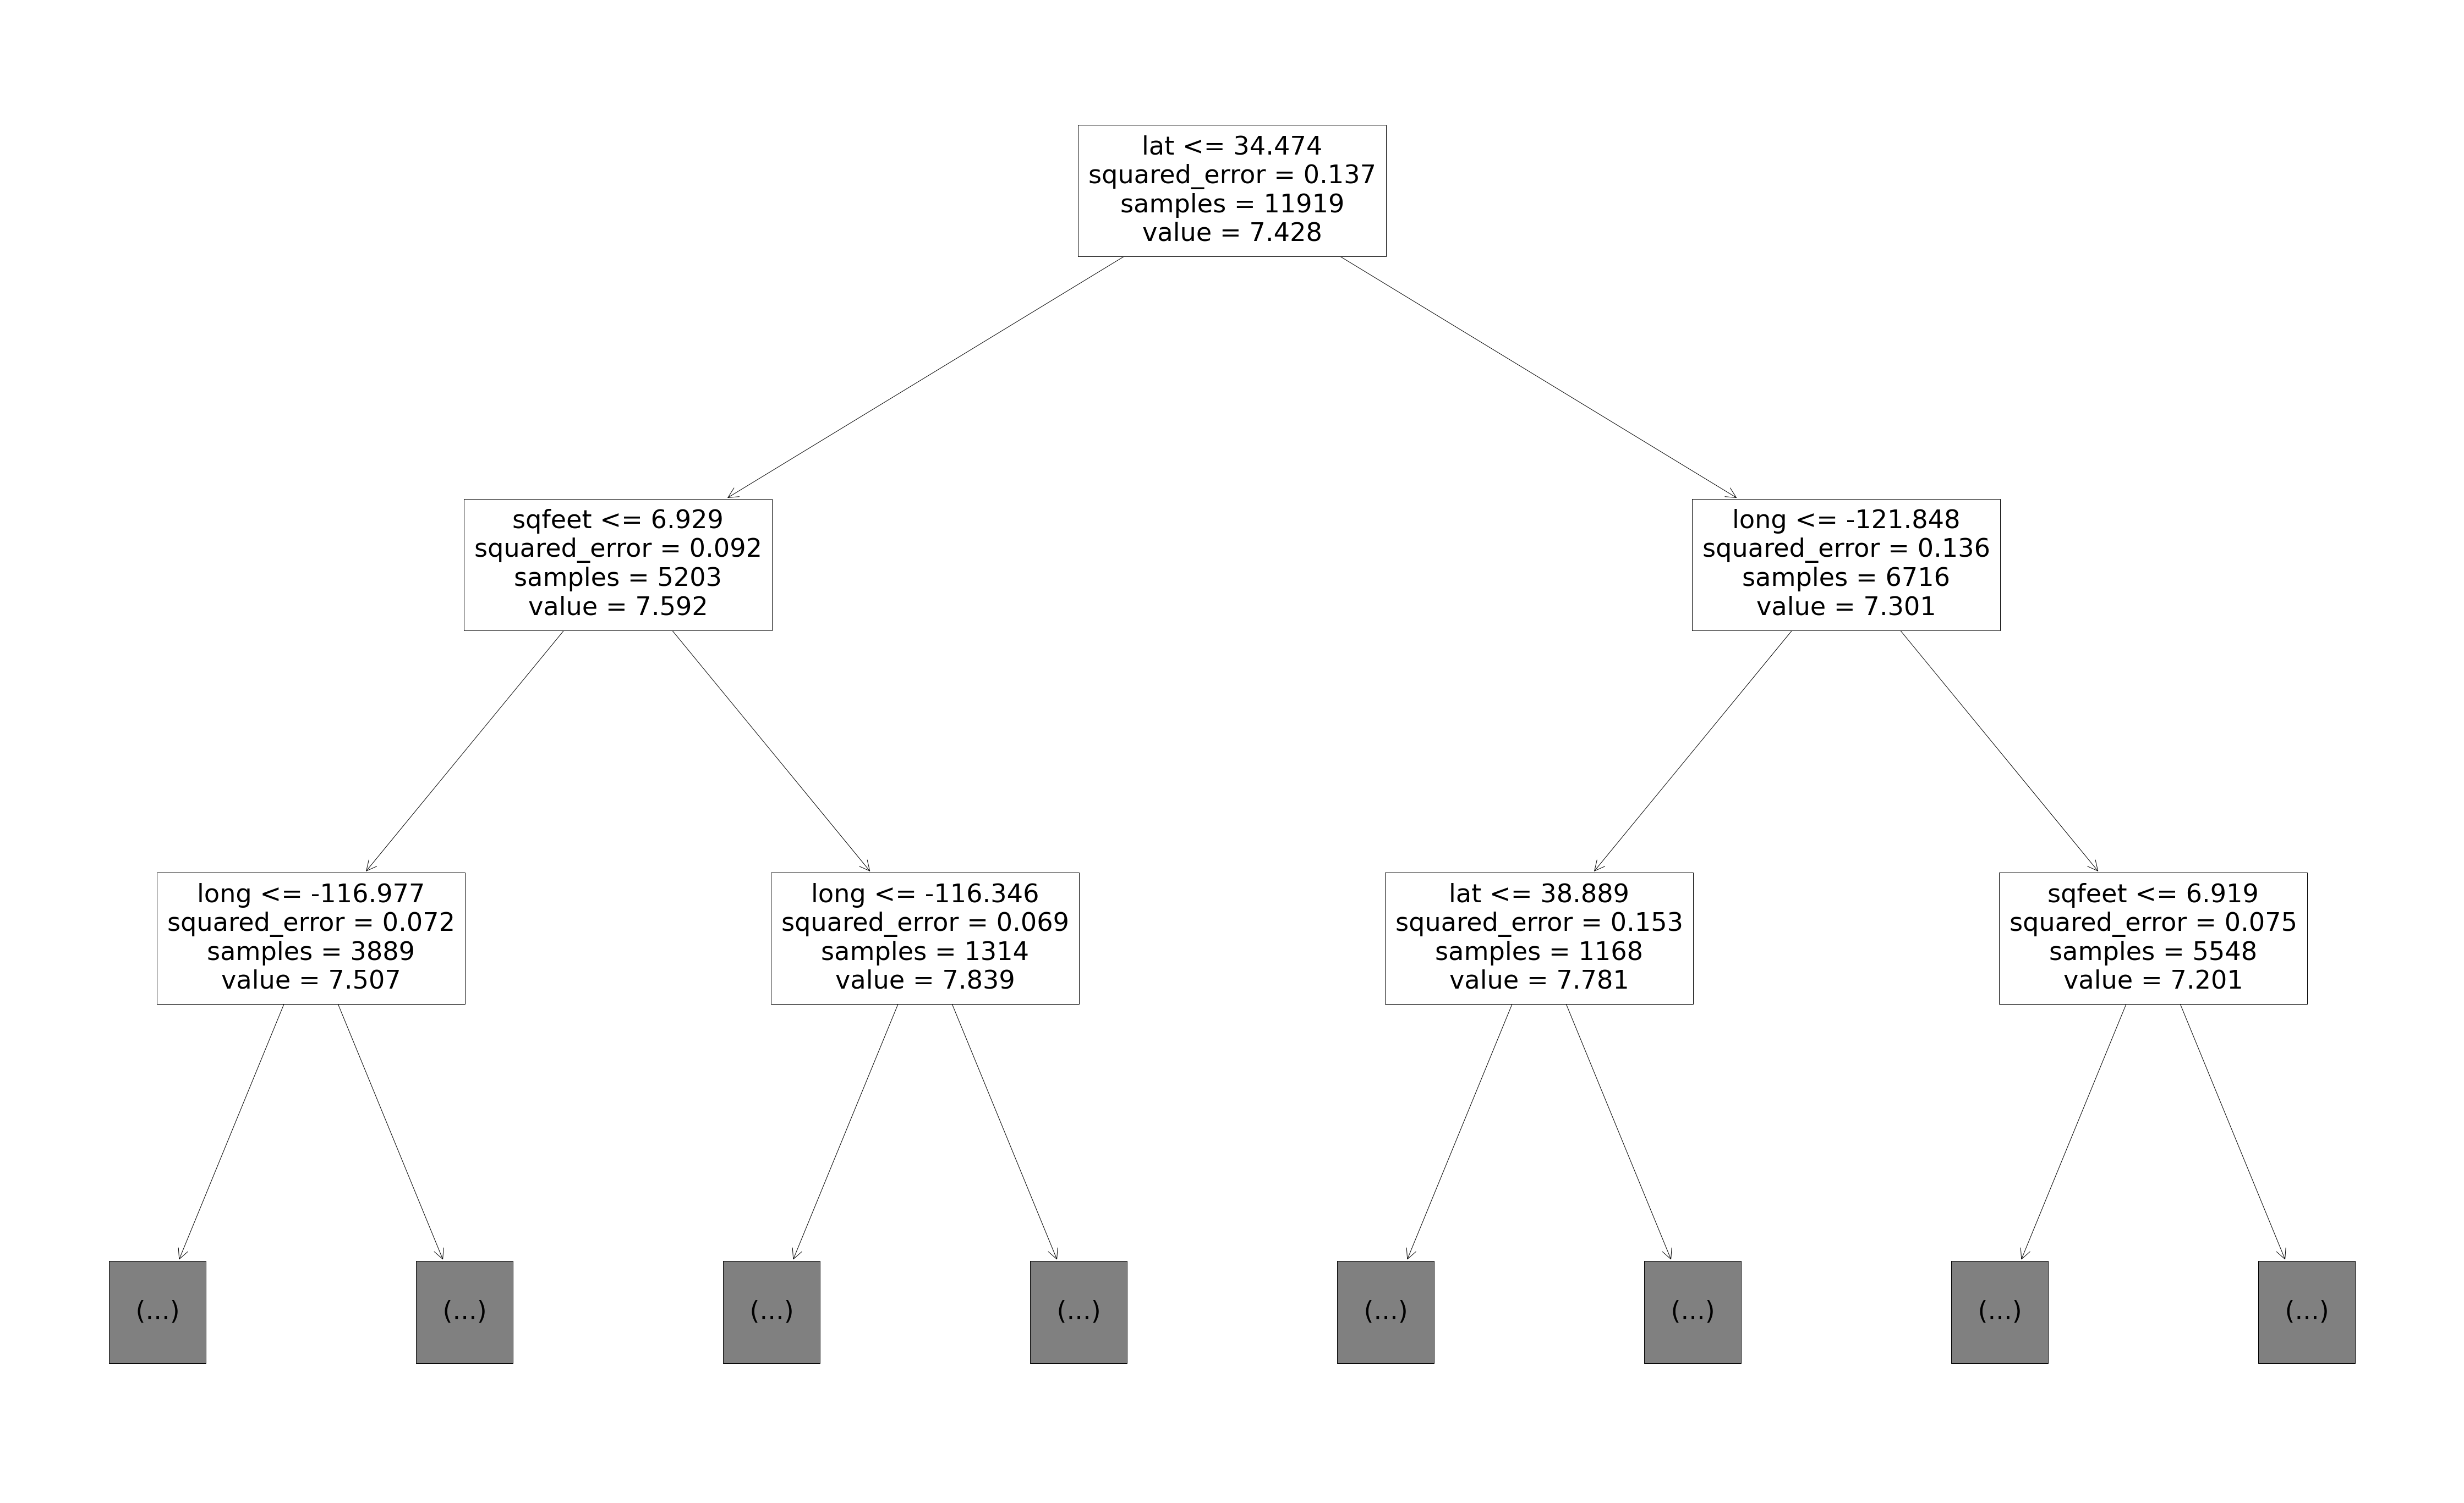

In [111]:
# plot of one of the trees of the random forest
# cut at 2 levels, for visualization
plot_tree(rf.estimators_[0], max_depth=2, feature_names=rf.feature_names_in_)

### option 3 - xgboost

#### without hyperparameter tunning

In [112]:
#!pip install -U xgboost --quiet

In [113]:
import xgboost as xgb

In [114]:
param = {
    'objective':'reg:squarederror',
    'verbosity':1,
    'learning_rate':0.3,
    'max_depth':10,
    'subsample':0.8, # to avoid overfitting
    'reg_lambda':0.1, # L2 reg
    'alpha':0, #L1 reg
    'max_leaves':10
}
n_estim = 20

In [115]:
data_train = xgb.DMatrix(X_train, label=y_train)
data_val = xgb.DMatrix(X_val, label=y_val)

In [116]:
time0 = time()
xgb_1 = xgb.train(param, data_train, n_estim)
print(time()-time0)

1.3370907306671143


In [117]:
yhat_train_xgb1 = xgb_1.predict(data_train)
yhat_val_xgb1 = xgb_1.predict(data_val)

In [118]:
printMetrics(y_train, yhat_train_xgb1)
print()
printMetrics(y_val, yhat_val_xgb1)

RMSE:  0.0581
MAE:  0.0407
MAPE:  0.0055
R2:  0.9752

RMSE:  0.0802
MAE:  0.0488
MAPE:  0.0065
R2:  0.9522


In [119]:
from xgboost import plot_importance, plot_tree

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

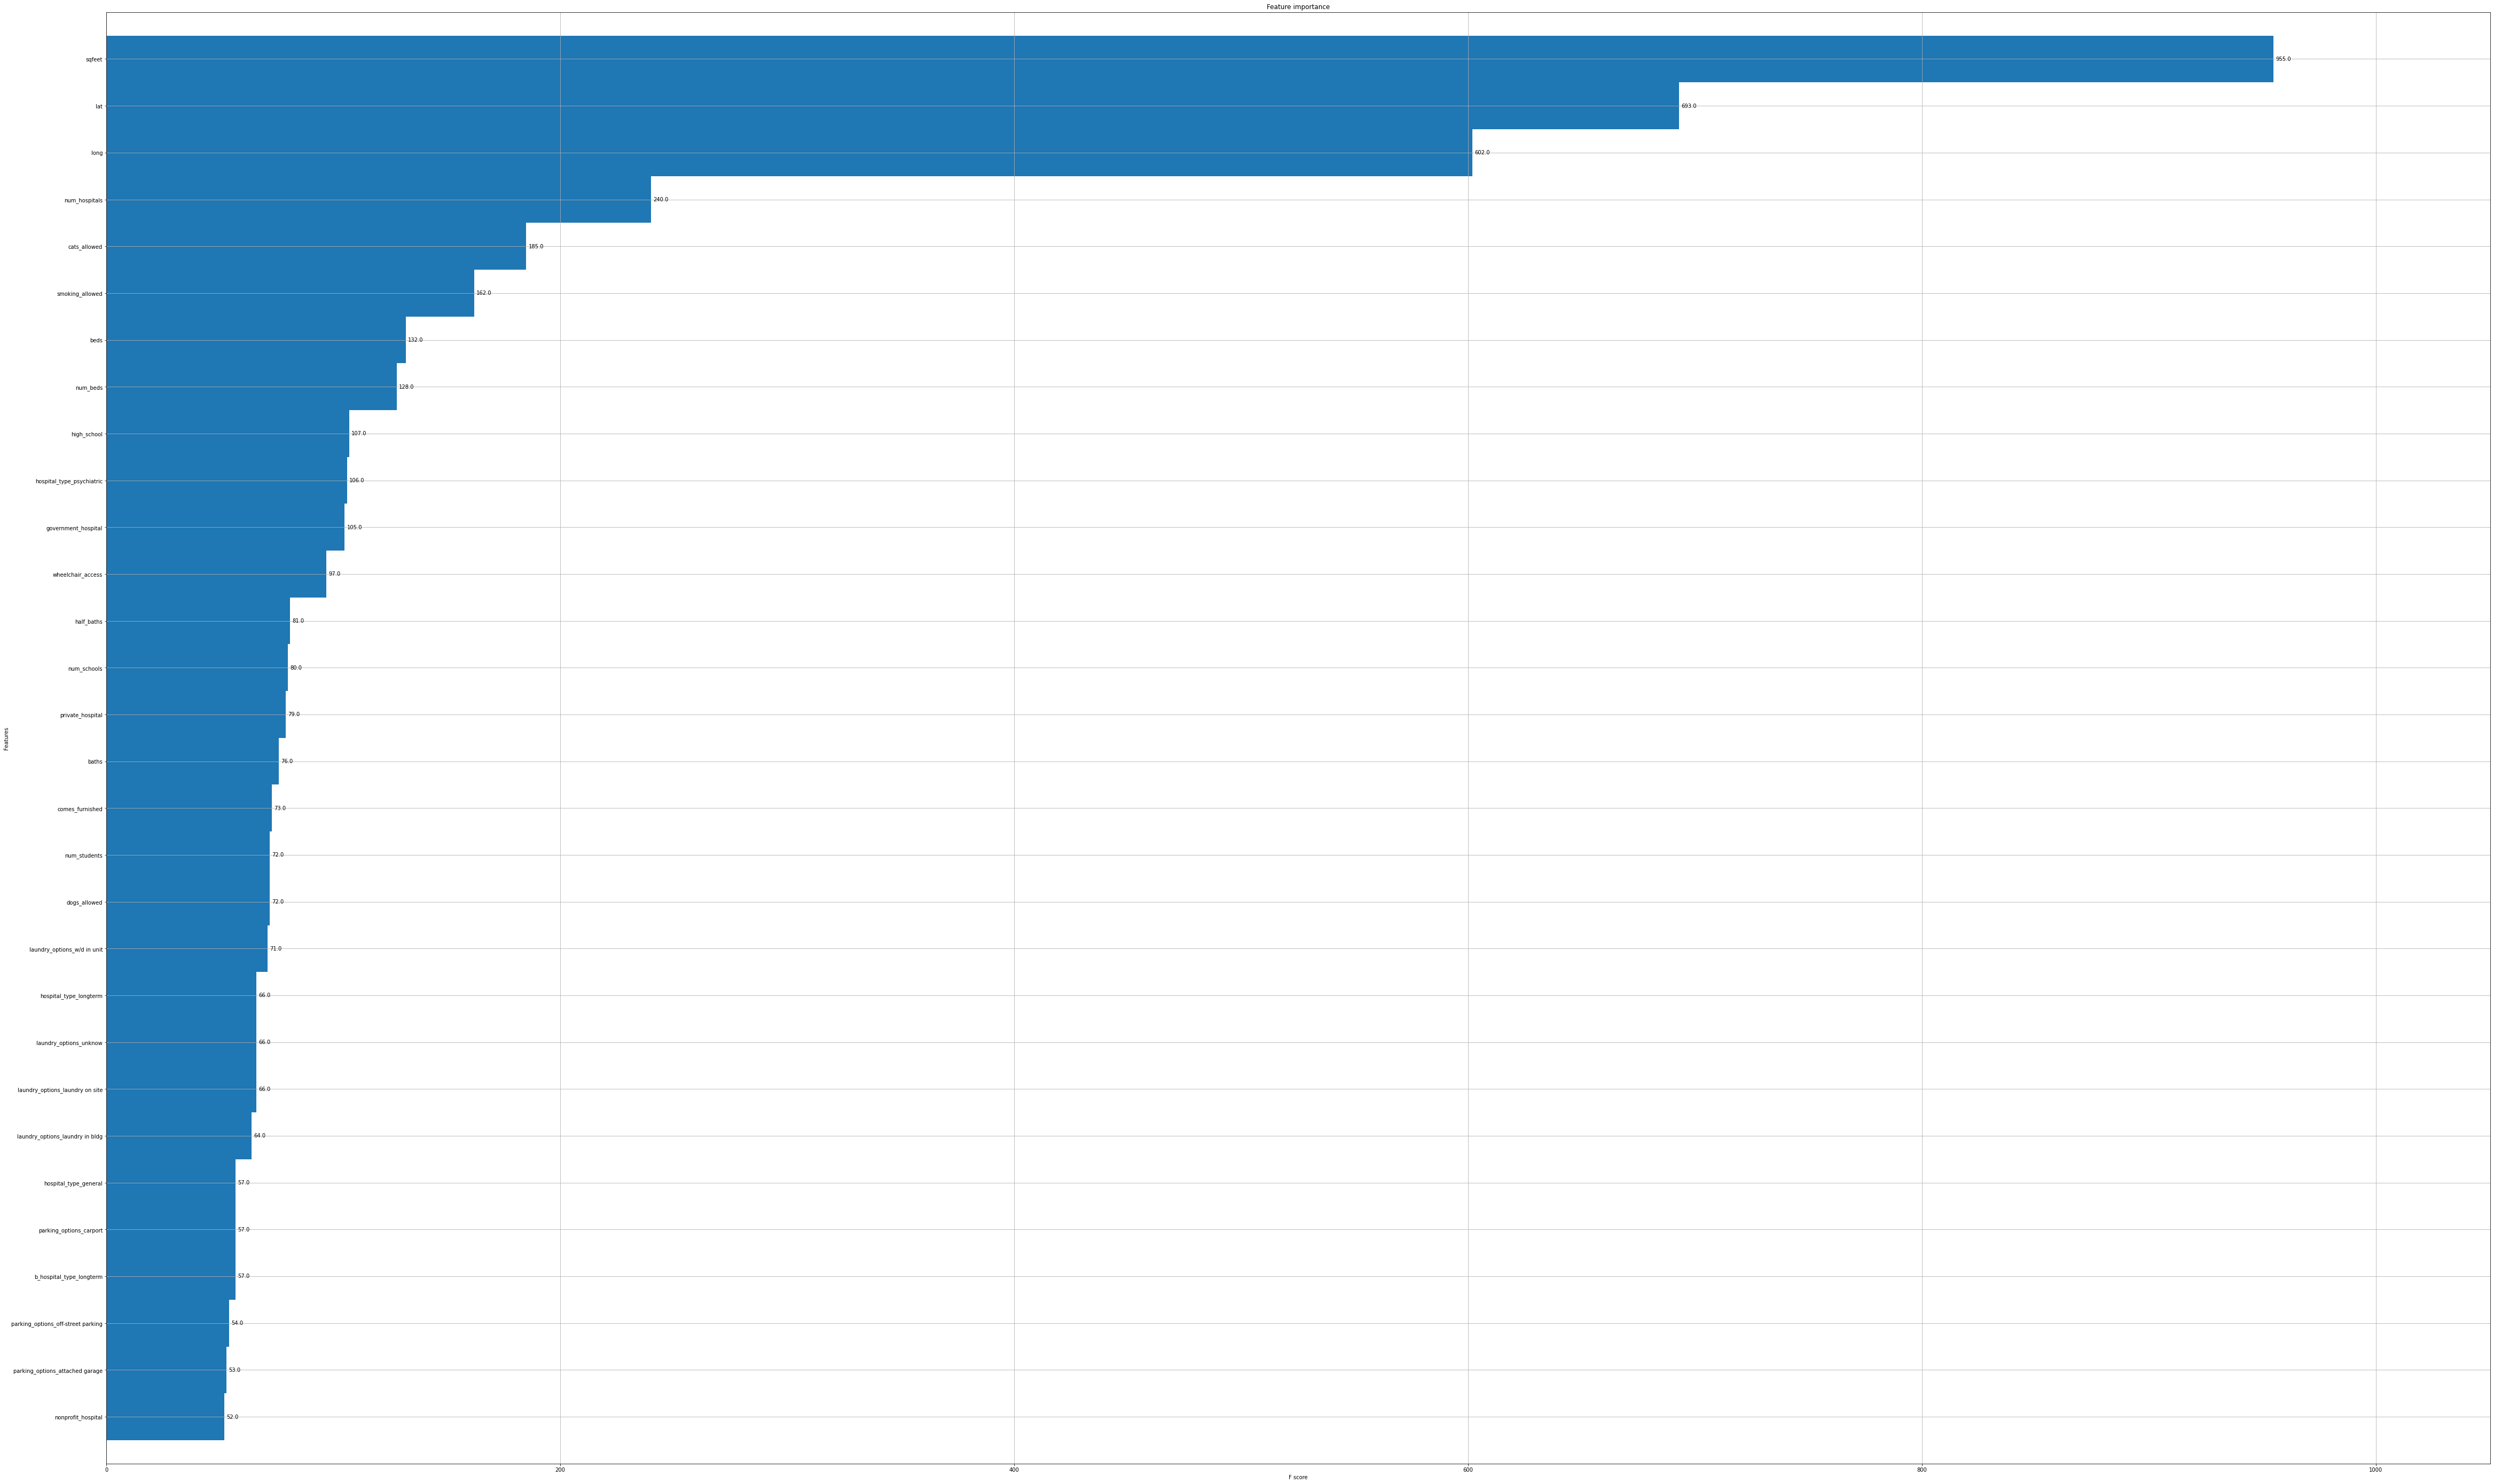

In [120]:
plot_importance(xgb_1, max_num_features = 30, height = 1)

In [121]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 80,50

In [ ]:
plt.figure(figsize=(10,10))
xgb.plot_tree(xgb_1, num_trees = 4, rankdir="LR")

In [ ]:
# if the previous cell (plot_tree) doesn't work, install graphviz from here and add it to the path:

#https://graphviz.org/download/
#import os
#os.environ["PATH"] += os.pathsep+'C:/Program Files (x86)/Graphviz/bin'

#### with hyperparameter tunning

In [123]:
from sklearn.model_selection import GridSearchCV

In [124]:
params = {
    #'objective':'reg:squarederror',
    #'verbosity':1,
    'learning_rate':[0.1, 0.3, 1],
    'max_depth':[5, 7, 10],
    'subsample':[0.8], # to avoid overfitting
    'reg_lambda':[0, 0.1, 1], # L2 reg
    'alpha':[0, 0.1, 1], #L1 reg
    'max_leaves':[10],
    'n_estimators':[5, 10, 20]
}


In [125]:
xgbr = xgb.XGBRegressor(seed = 20, objective = 'reg:squarederror', verbosity = 1)

time0 = time()
xgb_grid = GridSearchCV(estimator=xgbr, param_grid = params, cv = 3)
xgb_grid.fit(X_train, y_train)
# retrain with the best parameters:
xgb_cv = xgb.train(xgb_grid.best_params_, data_train, xgb_grid.best_params_['n_estimators'])

print(time()-time0) # time ~ 443s

[22:31:57] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

312.82209610939026


In [126]:
"""{'alpha': 0,
 'learning_rate': 0.3,
 'max_depth': 10,
 'max_leaves': 10,
 'n_estimators': 20,
 'reg_lambda': 0.1,
 'subsample': 0.8}"""
xgb_grid.best_params_

{'alpha': 0,
 'learning_rate': 0.3,
 'max_depth': 10,
 'max_leaves': 10,
 'n_estimators': 20,
 'reg_lambda': 0.1,
 'subsample': 0.8}

In [127]:
yhat_train_xgbcv = xgb_cv.predict(data_train)
yhat_val_xgbcv = xgb_cv.predict(data_val)

In [128]:
printMetrics(y_train, yhat_train_xgbcv)
print("")
printMetrics(y_val, yhat_val_xgbcv)

RMSE:  0.0581
MAE:  0.0407
MAPE:  0.0055
R2:  0.9752

RMSE:  0.0802
MAE:  0.0488
MAPE:  0.0065
R2:  0.9522


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

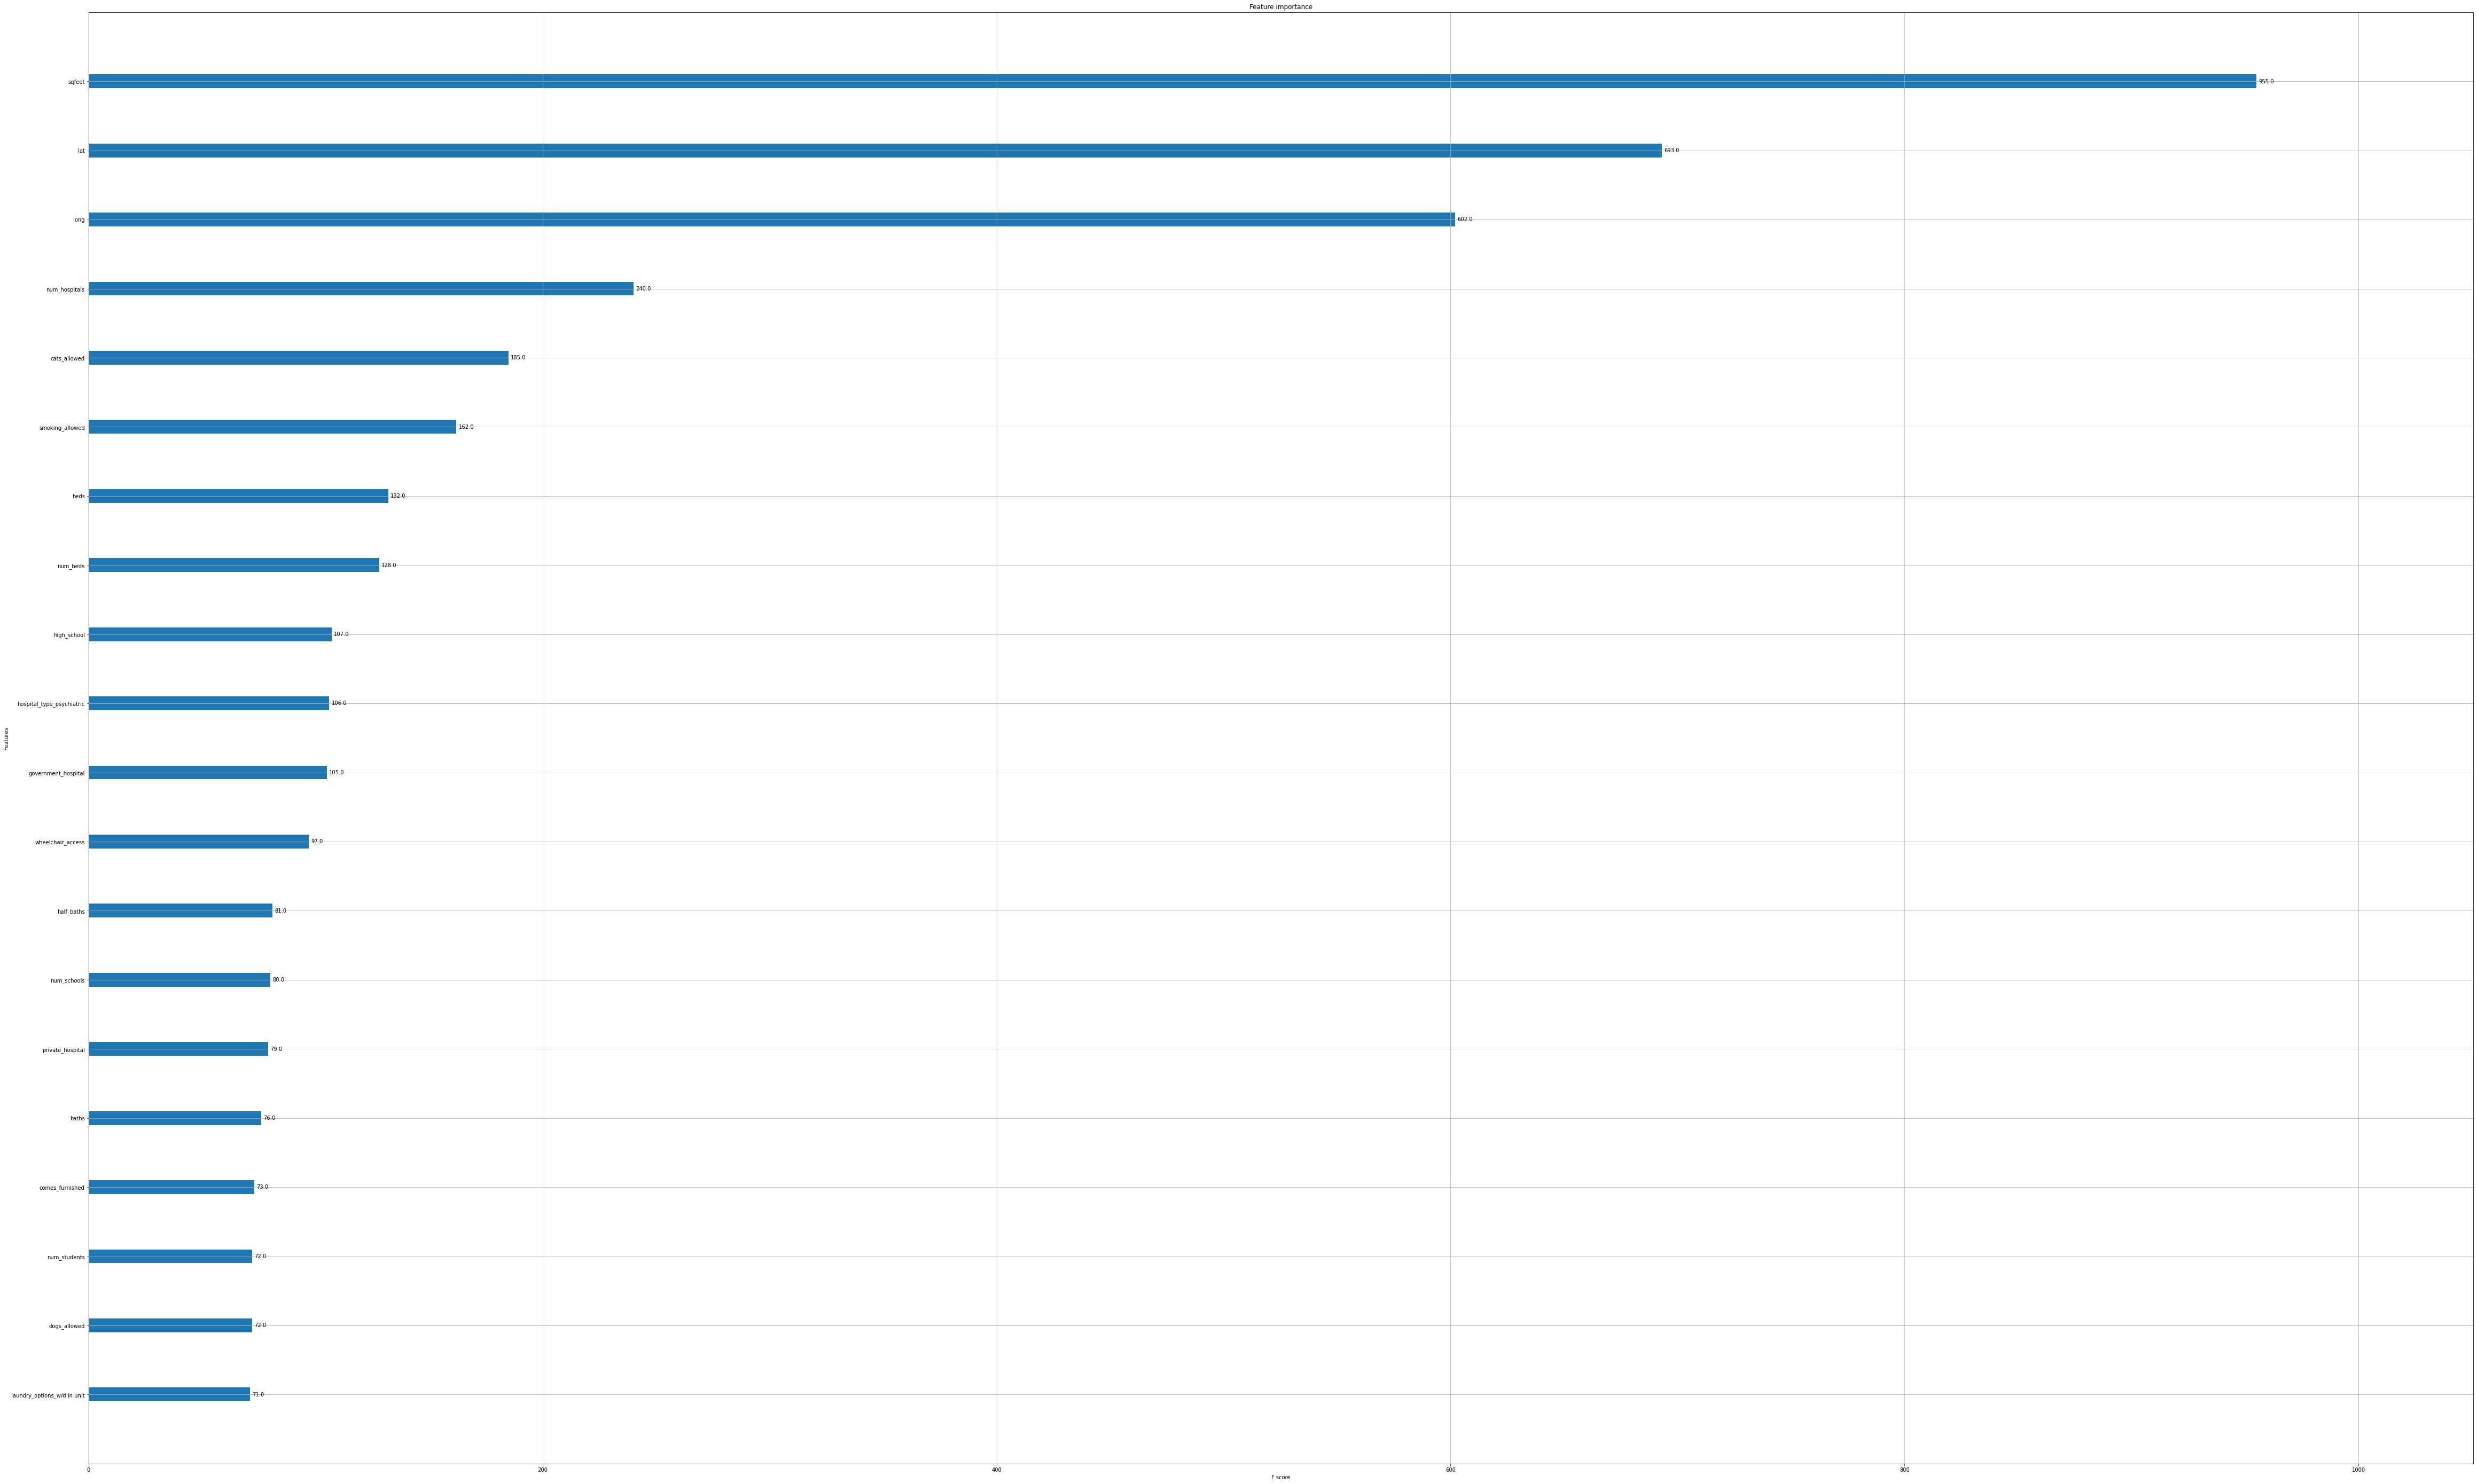

In [129]:
plot_importance(xgb_cv, max_num_features=20)

# plots

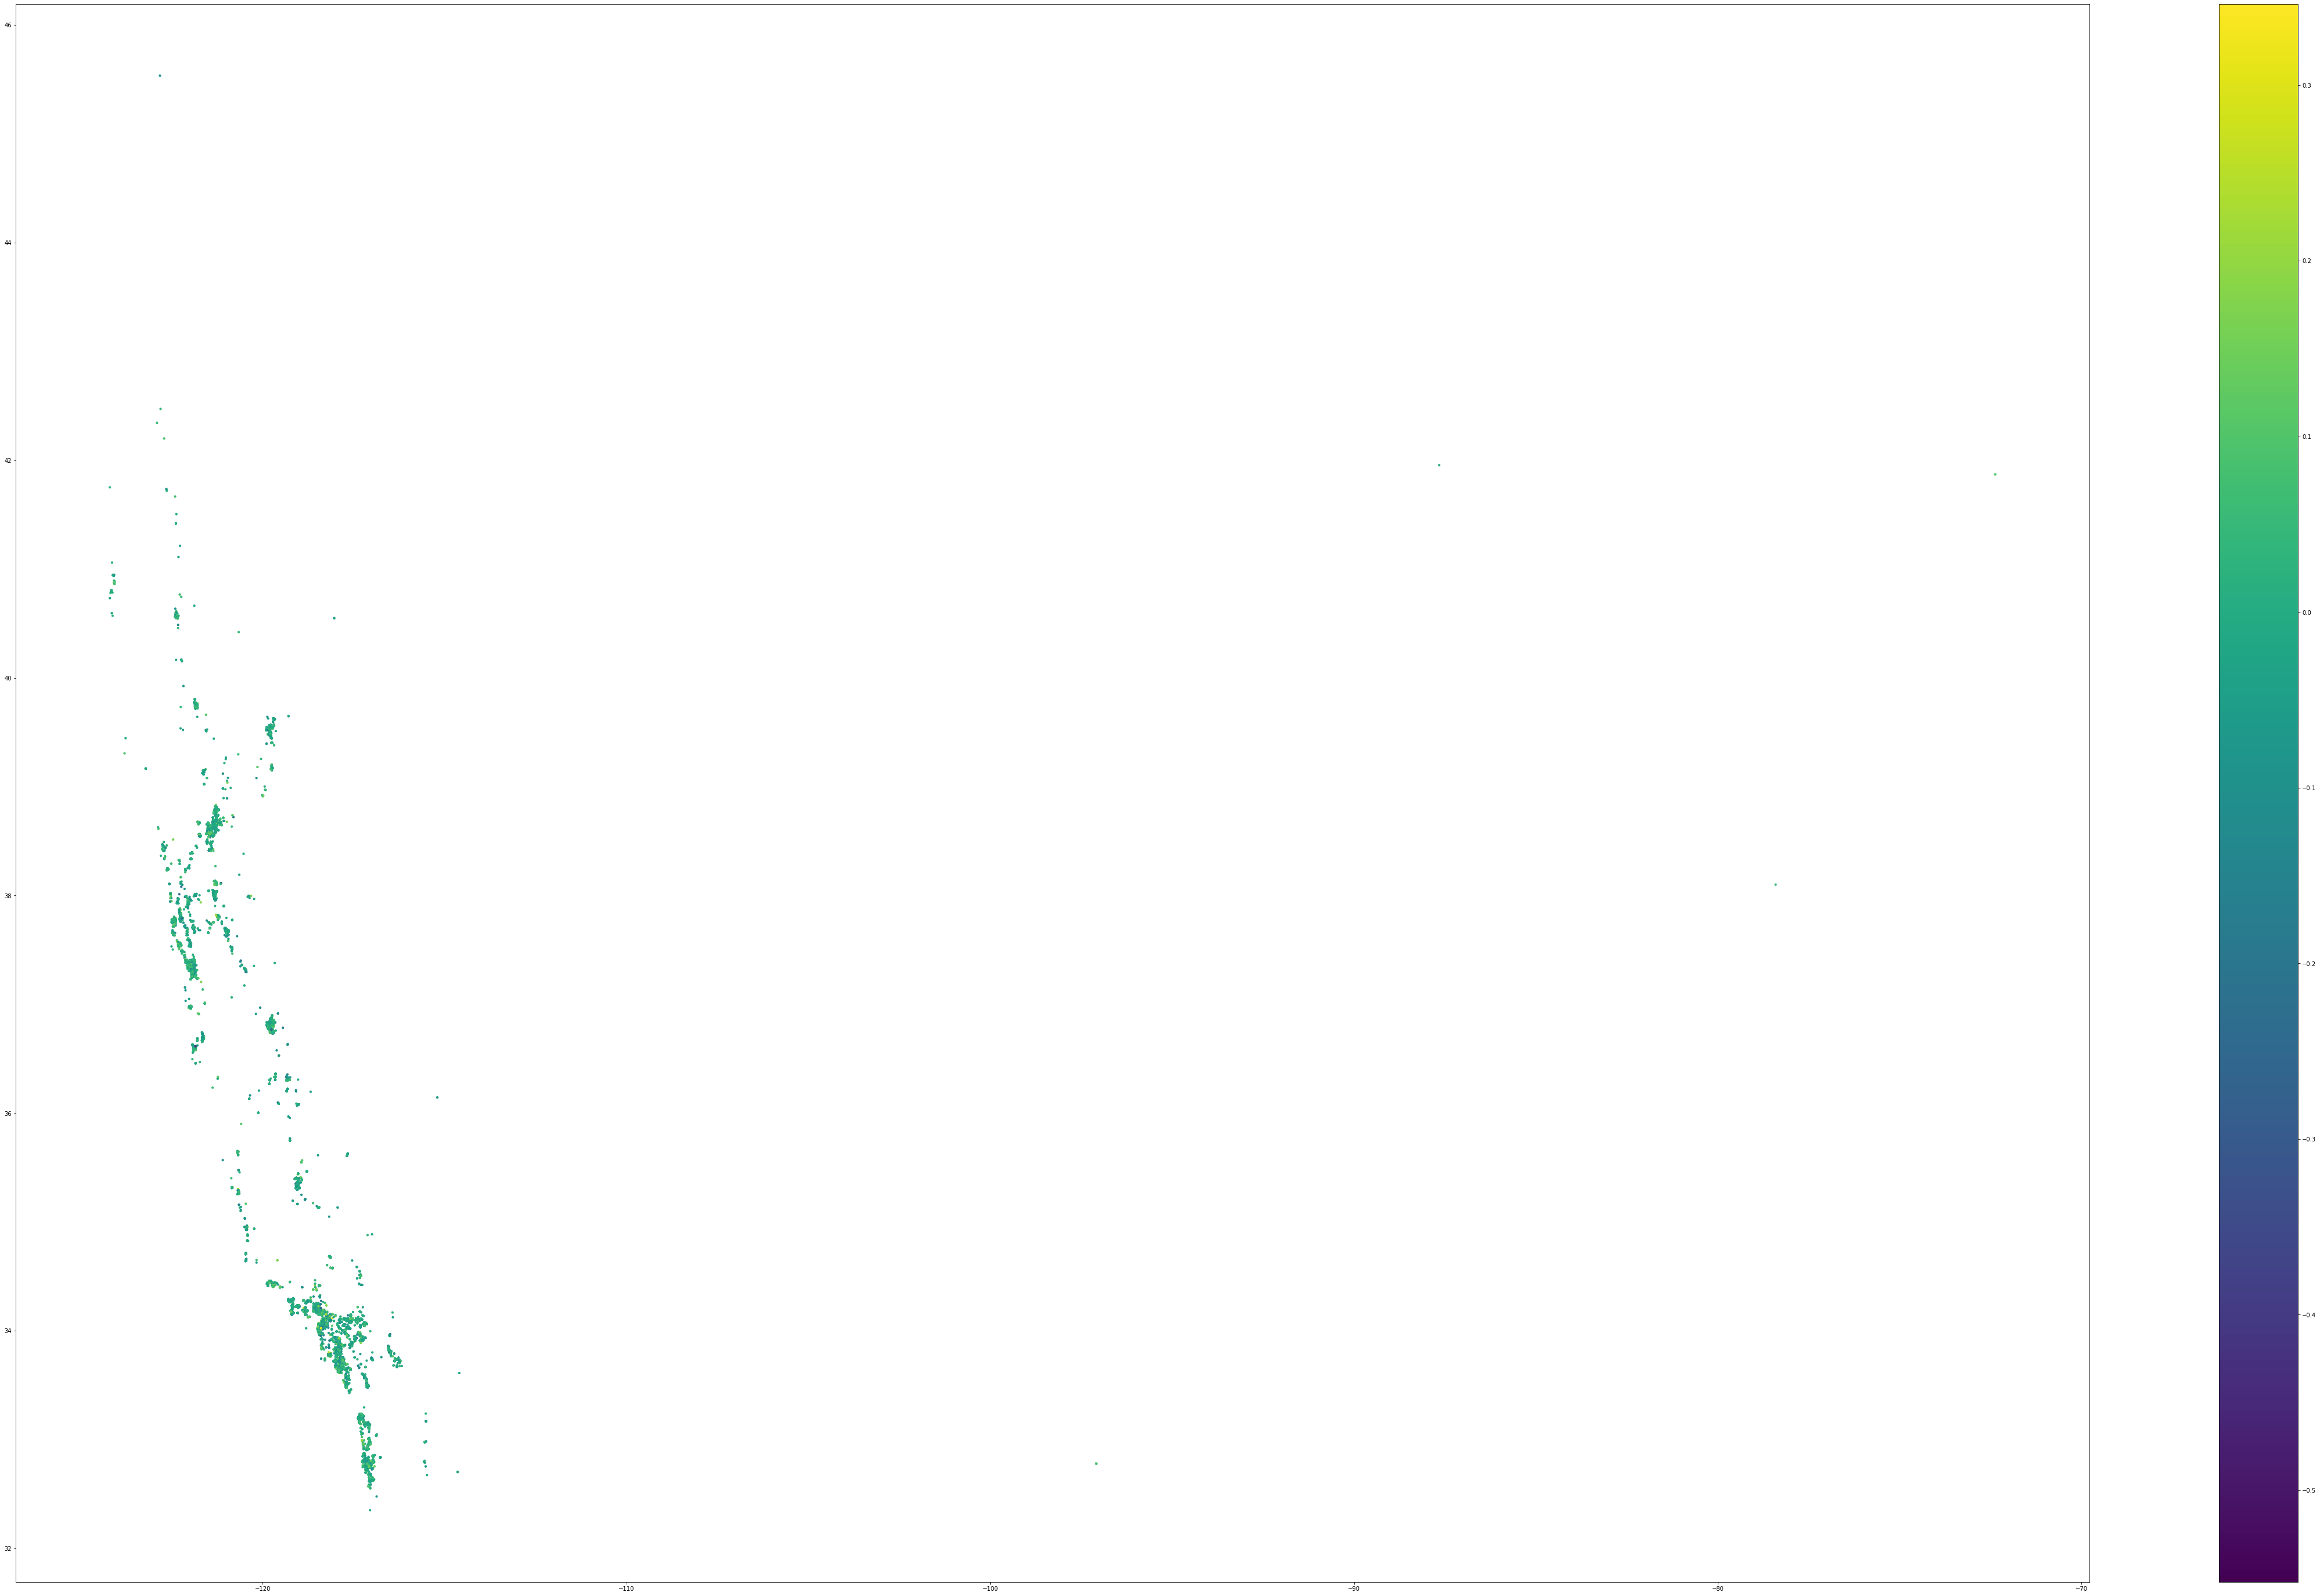

In [130]:
plt.scatter(X_train.long, X_train.lat, c=y_train-yhat_train_xgbcv, s=10)
plt.colorbar()

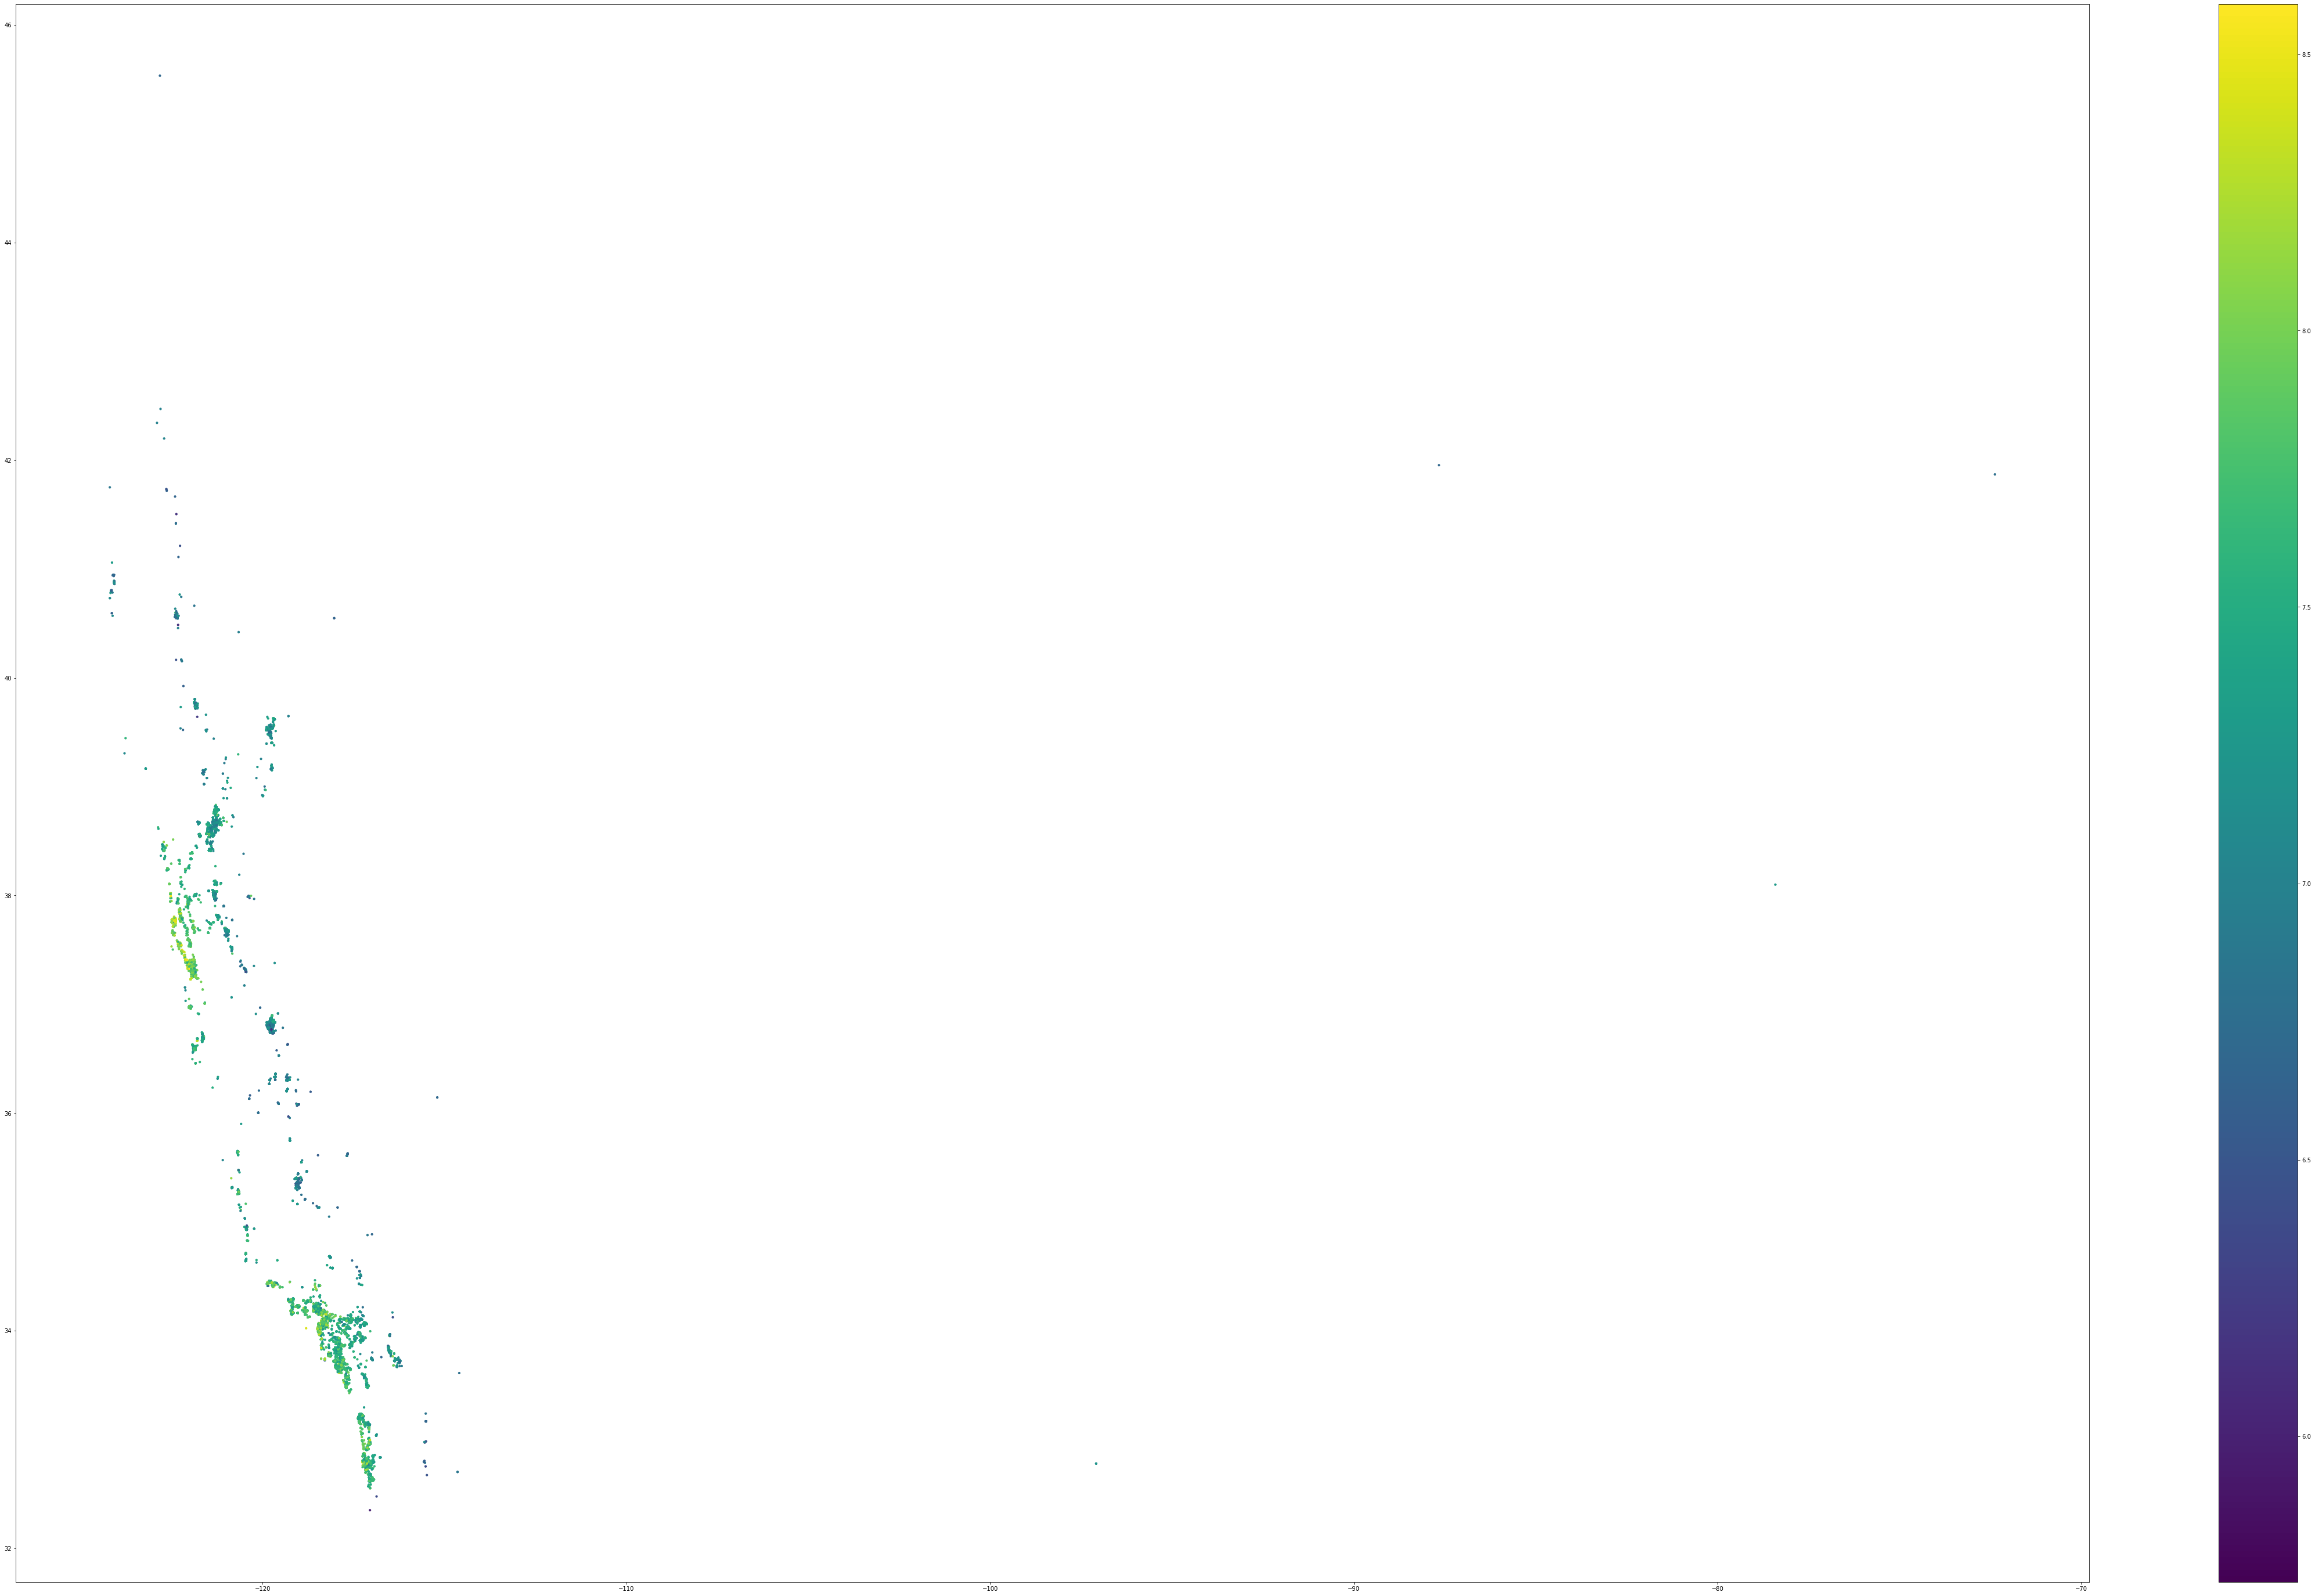

In [131]:
plt.scatter(X_train.long, X_train.lat, c=y_train, s=10)
plt.colorbar()